# Esfandiar Kiani - DL - Project (RSI-CB256)

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
from tqdm.notebook import tqdm
import random
import kornia
import torchvision.transforms as transforms
from IPython.display import display, clear_output
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.utils.data import WeightedRandomSampler

## Hyperparameters

In [6]:
hyperparameters = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "num_epochs": 70,
    "input_size": (64, 64),
    "num_classes": 4,
    "lstm_hidden_size": 98,
    "lstm_num_layers": 1,
    "patience": 1000
}

In [7]:
model_parameters = {
    "conv1_kernels": 8,
    "conv1_kernel_size": 3,
    "conv1_stride": 1,
    "conv1_padding": 1,
    "pool1_size": 2,
    "pool1_stride": 2,
    "conv2_kernels": 16,
    "conv2_kernel_size": 3,
    "conv2_stride": 1,
    "conv2_padding": 1,
    "pool2_size": 2,
    "pool2_stride": 2,
    "dense1_neurons": 64,
    "lstm_sequence_length": 32,
    "lstm_input_size": 128
}
seed = 13
dataset_path = "./RSI-CB256 (5631)"
best_model_path = "./saved_model_rsi/best_model_rsicb256.pkl"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset

In [33]:
class RSICB256Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['cloudy', 'desert', 'green_area', 'water']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []
        
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(class_dir, img_name)
                    # Check image size
                    # with Image.open(img_path) as img:
                    #     if img.size != (256, 256):
                    #         img = img.resize((256, 256), Image.Resampling.LANCZOS)
                    #         img.save(img_path)  # Overwrite with standard size
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Preprocessing data

In [34]:
data_transforms = transforms.Compose([
    transforms.Resize(hyperparameters["input_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: kornia.filters.laplacian(x.unsqueeze(0), kernel_size=3).squeeze(0) + x)
])

In [35]:
dataset = RSICB256Dataset(root_dir=dataset_path, transform=data_transforms)

## Train/Test Split

In [36]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

## Load data

In [37]:
train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)

In [38]:
print(f"Total images: {len(dataset)}")
print(f"Train images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Classes: {dataset.classes}")

Total images: 5631
Train images: 4504
Test images: 1127
Classes: ['cloudy', 'desert', 'green_area', 'water']


### Test Show

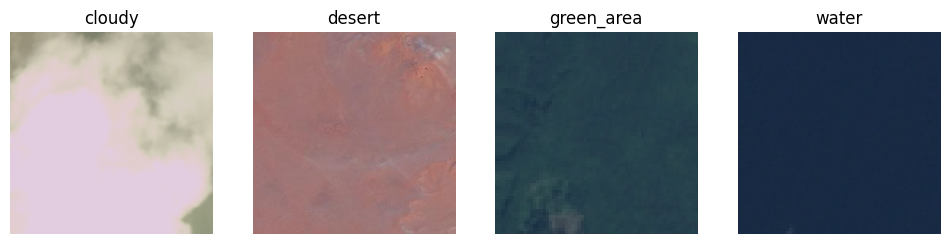

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, cls in enumerate(dataset.classes):
    cls_imgs = [img for img, lbl in zip(dataset.images, dataset.labels) if dataset.class_to_idx[cls] == lbl]
    img = Image.open(cls_imgs[0]).convert('RGB')
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.show()

## Model

In [9]:
class LightweightCNNLSTM(nn.Module):
    def __init__(self, num_classes, model_params):
        super(LightweightCNNLSTM, self).__init__()
        self.model_params = model_parameters
        self.cnn = nn.Sequential(
            nn.Conv2d(3, model_params["conv1_kernels"], kernel_size=model_params["conv1_kernel_size"], 
                      stride=model_params["conv1_stride"], padding=model_params["conv1_padding"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool1_size"], stride=model_params["pool1_stride"]),
            nn.Conv2d(model_params["conv1_kernels"], model_params["conv2_kernels"], 
                      kernel_size=model_params["conv2_kernel_size"], stride=model_params["conv2_stride"], 
                      padding=model_params["conv2_padding"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool2_size"], stride=model_params["pool2_stride"])
        )
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size=model_params["lstm_input_size"], 
                            hidden_size=hyperparameters["lstm_hidden_size"], 
                            num_layers=hyperparameters["lstm_num_layers"], 
                            batch_first=True)
        self.fc1 = nn.Linear(hyperparameters["lstm_hidden_size"], model_params["dense1_neurons"])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(model_params["dense1_neurons"], num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = x.view(x.size(0), self.model_params["lstm_sequence_length"], -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Train

In [41]:
model = LightweightCNNLSTM(num_classes=hyperparameters["num_classes"], model_params=model_parameters).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters["learning_rate"])

In [42]:
best_val_acc = 0.0
patience = hyperparameters["patience"]
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

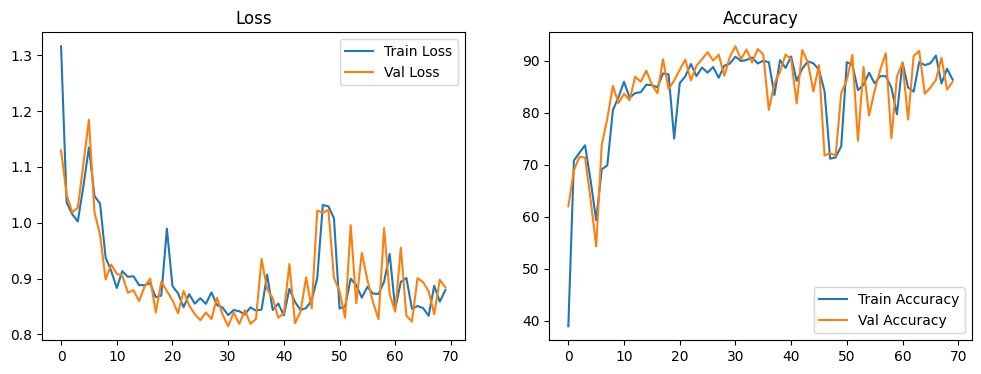

Epoch 70/70, Train Loss: 0.8795, Train Acc: 86.39%, Val Loss: 0.8844, Val Acc: 85.98%


In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for epoch in tqdm(range(hyperparameters["num_epochs"]), desc="Epochs"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        counter = 0
    else:
        counter += 1
    
    clear_output(wait=True)
    ax1.clear()
    ax2.clear()
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Val Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    display(fig)
    
    print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if counter >= patience:
        print("Early stopping triggered.")
        break

plt.close()

## Evaluation

In [20]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
all_preds = []
all_labels = []

C:\Users\Stephen\AppData\Local\Temp\ipykernel_16936\807321686.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [21]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [22]:
accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

## Result

In [23]:
print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Final Test Accuracy: 92.81%
Precision: 0.9293
Recall: 0.9281
F1-Score: 0.9281


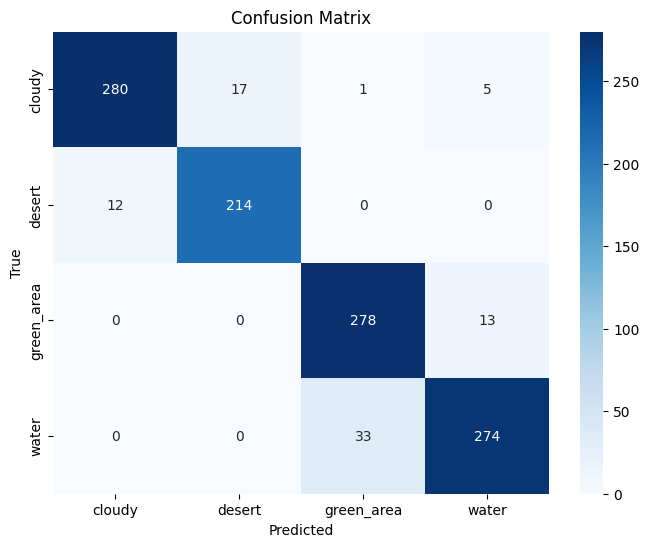

In [24]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

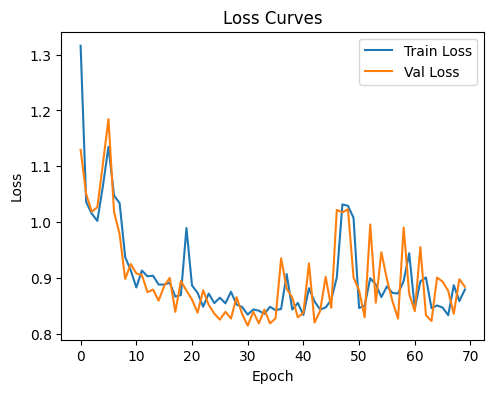

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

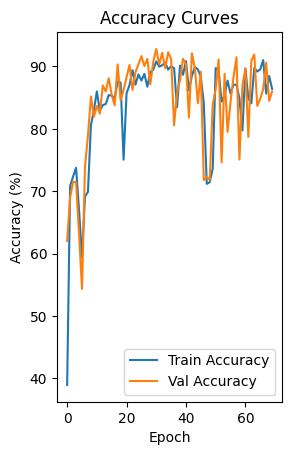

In [26]:
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Live Run

In [1]:
import os, random, numpy as np, cv2, torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import math, random, numpy as np, torch, kornia, os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns


SEED = 13
BATCH_SIZE = 32
SUBSET_SAMPLES = 40
PER_CLASS_SAMPLES = 4
BATCH_SIZE_DEMO = 6
IMAGE_SIZE = 64
INPUT_SIZE = (64, 64)
USE_SHARPEN = True
SHOW_CONF = True

DATA_ROOT_RSI = "../Dataset/RSI-CB256 (5631)"
WEIGHT_PATH   = "./saved_model_rsi/best_model_rsicb256.pkl"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
os.environ["OMP_NUM_THREADS"]="1"; os.environ["MKL_NUM_THREADS"]="1"; cv2.setNumThreads(0); torch.set_num_threads(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


hyperparameters = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "num_epochs": 70,
    "input_size": (64, 64),
    "num_classes": 4,
    "lstm_hidden_size": 98,
    "lstm_num_layers": 1,
    "patience": 1000
}

model_parameters = {
    "conv1_kernels": 8,
    "conv1_kernel_size": 3,
    "conv1_stride": 1,
    "conv1_padding": 1,
    "pool1_size": 2,
    "pool1_stride": 2,
    "conv2_kernels": 16,
    "conv2_kernel_size": 3,
    "conv2_stride": 1,
    "conv2_padding": 1,
    "pool2_size": 2,
    "pool2_stride": 2,
    "dense1_neurons": 64,
    "lstm_sequence_length": 32,
    "lstm_input_size": 128
}
seed = 13


class LightweightCNNLSTM(nn.Module):
    def __init__(self, num_classes, model_params):
        super(LightweightCNNLSTM, self).__init__()
        self.model_params = model_parameters
        self.cnn = nn.Sequential(
            nn.Conv2d(3, model_params["conv1_kernels"], kernel_size=model_params["conv1_kernel_size"], 
                      stride=model_params["conv1_stride"], padding=model_params["conv1_padding"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool1_size"], stride=model_params["pool1_stride"]),
            nn.Conv2d(model_params["conv1_kernels"], model_params["conv2_kernels"], 
                      kernel_size=model_params["conv2_kernel_size"], stride=model_params["conv2_stride"], 
                      padding=model_params["conv2_padding"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool2_size"], stride=model_params["pool2_stride"])
        )
        self.flatten = nn.Flatten()
        self.lstm = nn.LSTM(input_size=model_params["lstm_input_size"], 
                            hidden_size=hyperparameters["lstm_hidden_size"], 
                            num_layers=hyperparameters["lstm_num_layers"], 
                            batch_first=True)
        self.fc1 = nn.Linear(hyperparameters["lstm_hidden_size"], model_params["dense1_neurons"])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(model_params["dense1_neurons"], num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = x.view(x.size(0), self.model_params["lstm_sequence_length"], -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

full_ds = datasets.ImageFolder(DATA_ROOT_RSI)
num_classes = len(full_ds.classes)
model = LightweightCNNLSTM(num_classes=num_classes, model_params=model_parameters).to(device)
state = torch.load(WEIGHT_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

device: cuda


LightweightCNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lstm): LSTM(128, 98, batch_first=True)
  (fc1): Linear(in_features=98, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

Subset Accuracy: 66.67%
Precision: 0.6250
Recall: 0.6250
F1-Score: 0.6250


C:\Users\Stephen\AppData\Local\Temp\ipykernel_30416\1517380193.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yb = torch.tensor(yb, device=device)


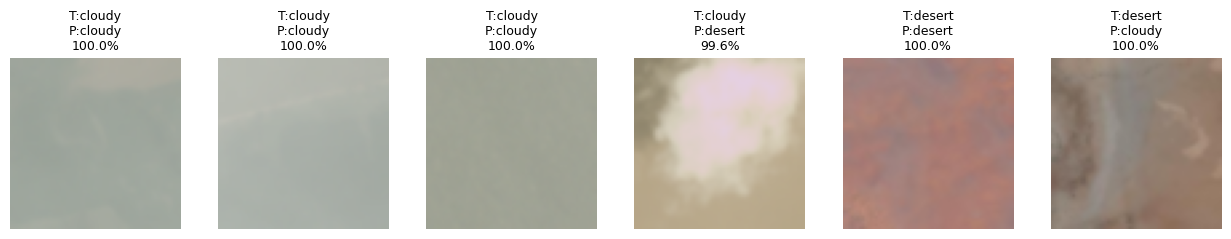

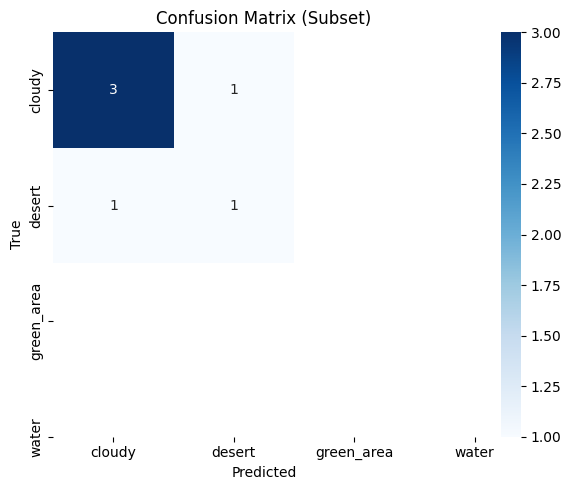

In [5]:
classes = full_ds.classes

base_tf = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


class LaplacianResidual:
    def __init__(self, k=3):
        self.k = k

    def __call__(self, x):
        y = kornia.filters.laplacian(
            x.unsqueeze(0), kernel_size=self.k).squeeze(0)
        return x + y


demo_tf = transforms.Compose([base_tf, LaplacianResidual(k=3)])

by_class = {}
for i, (p, y) in enumerate(full_ds.samples):
    by_class.setdefault(y, []).append(i)
indices = []
for y, idxs in by_class.items():
    random.shuffle(idxs)
    indices.extend(idxs[:PER_CLASS_SAMPLES])
if len(indices) < SUBSET_SAMPLES:
    pool = list(set(range(len(full_ds))) - set(indices))
    random.shuffle(pool)
    indices += pool[:SUBSET_SAMPLES - len(indices)]
indices = indices[:SUBSET_SAMPLES]
subset = torch.utils.data.Subset(full_ds, indices)


class RAMSubset(Dataset):
    def __init__(self, subset, tf):
        self.tf = tf
        self.items = []
        for i in range(len(subset)):
            path, y = subset.dataset.samples[subset.indices[i]]
            img = Image.open(path).convert("RGB")
            self.items.append((img.copy(), y, os.path.basename(path)))

    def __len__(self): return len(self.items)

    def __getitem__(self, i):
        img, y, name = self.items[i]
        x = self.tf(img)
        return x, y, name


ram_ds = RAMSubset(subset, demo_tf)
loader = DataLoader(ram_ds, batch_size=min(BATCH_SIZE_DEMO, len(
    ram_ds)), shuffle=False, num_workers=0, pin_memory=True)


xb, yb, names = next(iter(loader))
xb = xb.to(device)
yb = torch.tensor(yb, device=device)

with torch.no_grad():
    probs = model(xb)
    pred = probs.argmax(1)

acc = 100.0 * (pred == yb).float().mean().item()
prec = precision_score(yb.cpu().numpy(), pred.cpu().numpy(),
                       average='macro', zero_division=0)
rec = recall_score(yb.cpu().numpy(), pred.cpu().numpy(),
                   average='macro', zero_division=0)
f1 = f1_score(yb.cpu().numpy(), pred.cpu().numpy(),
              average='macro', zero_division=0)
cm = confusion_matrix(yb.cpu().numpy(), pred.cpu().numpy())

print(f"Subset Accuracy: {acc:.2f}%")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")

n = xb.size(0)
cols = 8
rows = int(np.ceil(n/cols))
plt.figure(figsize=(cols*2.1, rows*2.3))
for i in range(n):
    img = xb[i].detach().cpu()
    img = (img * 0.5) + 0.5
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    t = int(yb[i].item())
    p = int(pred[i].item())
    conf = float(probs[i, p].item())
    title = f"T:{classes[t]}\nP:{classes[p]}\n{conf*100:.1f}%"
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.set_title(title, fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Subset)")
plt.tight_layout()
plt.show()

In [3]:
import torch
from torchinfo import summary


summary(model, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
LightweightCNNLSTM                       [1, 4]                    --
├─Sequential: 1-1                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            224
│    └─ReLU: 2-2                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-3                    [1, 8, 32, 32]            --
│    └─Conv2d: 2-4                       [1, 16, 32, 32]           1,168
│    └─ReLU: 2-5                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-6                    [1, 16, 16, 16]           --
├─Flatten: 1-2                           [1, 4096]                 --
├─LSTM: 1-3                              [1, 32, 98]               89,376
├─Linear: 1-4                            [1, 64]                   6,336
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 4]                    260
├─S

## Enhancement

### Type-1 (Same Model)

In [16]:
model = LightweightCNNLSTM(num_classes=hyperparameters["num_classes"], model_params=model_parameters).to(device)
# model.load_state_dict(torch.load(best_model_path))
# model.eval()
# print("Model loaded successfully from", best_model_path)

In [17]:
use_augmentation = True      
use_optimization = True    
use_preprocessing = True  
use_class_imbalance = True  
load_previous_weights = False  

In [18]:
def apply_clahe(image):
    image_pil = transforms.functional.to_pil_image(image)
    image_hsv = image_pil.convert('HSV')
    h, s, v = image_hsv.split()
    v = transforms.functional.adjust_contrast(v, contrast_factor=1.2)  
    image_hsv = Image.merge('HSV', (h, s, v))
    return transforms.functional.to_tensor(image_hsv.convert('RGB'))

def apply_laplacian(image):
    return kornia.filters.laplacian(image.unsqueeze(0), kernel_size=3).squeeze(0) + image

def compute_mean_std(dataset):
    transform = transforms.ToTensor()
    mean, std = 0, 0
    for img, _ in dataset:
        img = transform(img).numpy()
        mean += img.mean(axis=(1, 2))  
        std += img.std(axis=(1, 2))   
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

temp_dataset = RSICB256Dataset(root_dir=dataset_path, transform=None)
mean, std = compute_mean_std(temp_dataset)
print(f"Computed mean: {mean}, std: {std}")

if use_augmentation or use_preprocessing:
    data_transforms = transforms.Compose([
        transforms.Resize(hyperparameters["input_size"]),
        transforms.RandomRotation(30), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(hyperparameters["input_size"], scale=(0.9, 1.0)), 
        transforms.ColorJitter(brightness=0.1, contrast=0.1), 
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3)), 
        transforms.ToTensor(),
    ])
    if use_preprocessing:
        data_transforms.transforms.extend([
            transforms.Lambda(apply_clahe),
            transforms.Normalize(mean=mean, std=std), 
            transforms.Lambda(apply_laplacian)
        ])
else:
    data_transforms = transforms.Compose([
        transforms.Resize(hyperparameters["input_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

dataset = RSICB256Dataset(root_dir=dataset_path, transform=data_transforms)
print(f"Total dataset length: {len(dataset)}")

# Debug: Test __getitem__ for all indices
# for i in range(len(dataset)):
#     try:
#         image, label = dataset[i]
#         print(f"Index {i} loaded successfully, label: {label}")
#     except Exception as e:
#         print(f"Error at index {i}: {e}")
#         break

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")

try:
    sample_idx = 0
    image, label = train_dataset[sample_idx]
    print(f"Sample from train_dataset at index {sample_idx}: label {label}, shape {image.shape}")
except Exception as e:
    print(f"Error loading sample from train_dataset: {e}")

Computed mean: [0.4001199  0.43132994 0.42748356], std: [0.02285581 0.02053265 0.01887739]
Total dataset length: 5631
Train size: 4504, Test size: 1127
Sample from train_dataset at index 0: label 0, shape torch.Size([3, 64, 64])


In [19]:
if use_class_imbalance:
    from torch.utils.data import WeightedRandomSampler
    class_counts = np.bincount([label for _, label in dataset])  
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum()  
    train_indices = list(range(len(train_dataset)))  
    sample_weights = [class_weights[dataset[idx][1]] for idx in train_indices]  
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], sampler=sampler, num_workers=0, pin_memory=True) 
else:
    train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=True, num_workers=0, pin_memory=True) 
test_loader = DataLoader(test_dataset, batch_size=hyperparameters["batch_size"], shuffle=False, num_workers=0, pin_memory=True) 

In [20]:
if use_optimization:
    from torch.cuda.amp import GradScaler, autocast
    optimizer = optim.AdamW(model.parameters(), lr=hyperparameters["learning_rate"], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hyperparameters["num_epochs"], eta_min=1e-6)
    scaler = GradScaler()
    best_val_f1 = 0.0

if load_previous_weights:
    model.load_state_dict(torch.load(best_model_path))
    print("Model loaded successfully from best_model_rsicb256.pth")
else:
    model = LightweightCNNLSTM(num_classes=hyperparameters["num_classes"], model_params=model_parameters).to(device)
    print("Model initialized from scratch")

Model initialized from scratch


C:\Users\Stephen\AppData\Local\Temp\ipykernel_3620\4285108496.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [21]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

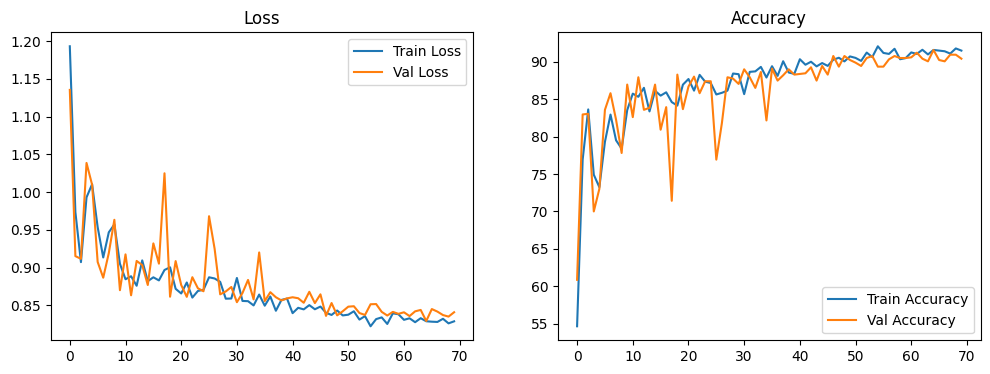

Epoch 70/70, Train Loss: 0.8287, Train Acc: 91.50%, Val Loss: 0.8408, Val Acc: 90.42%, Val F1: 0.9039


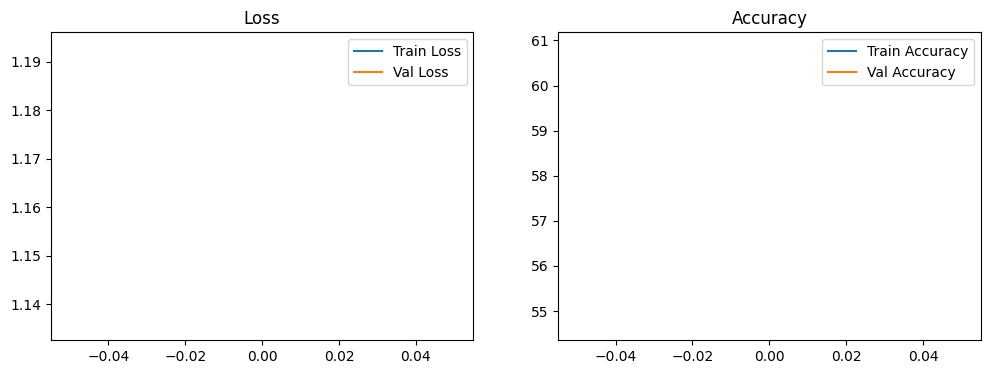

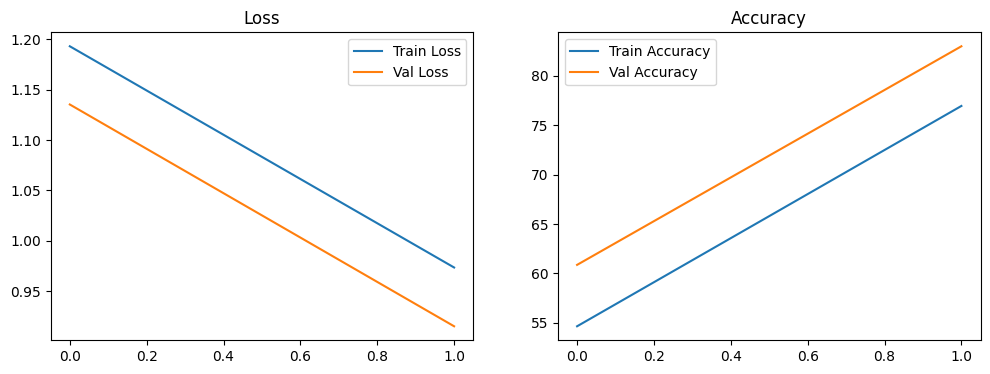

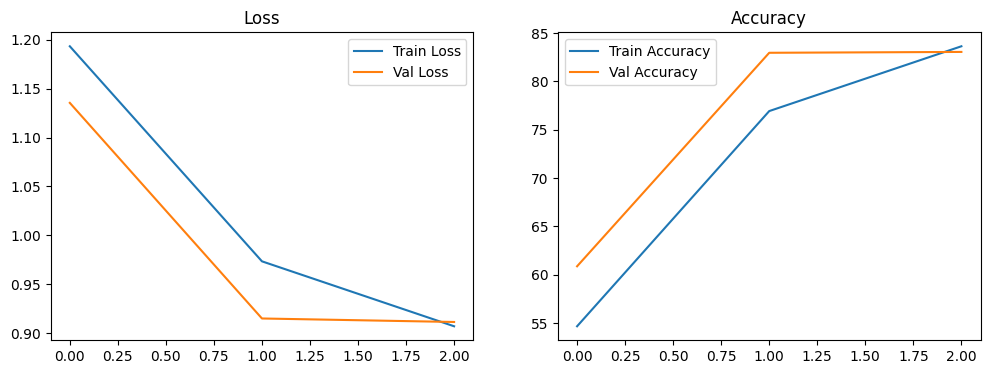

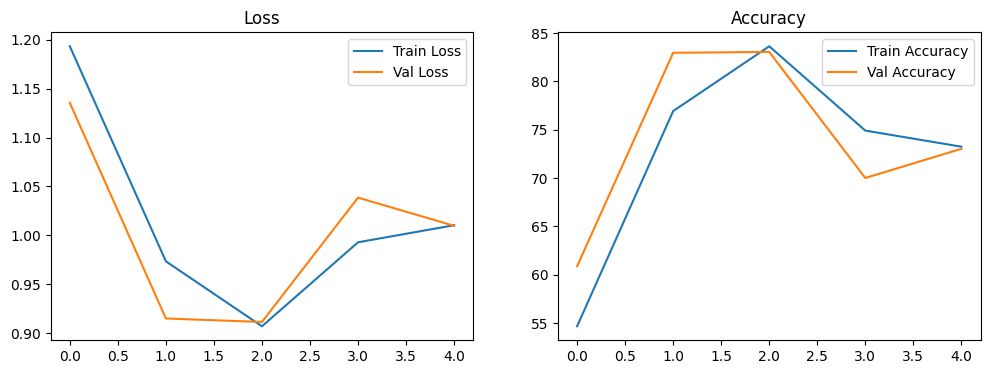

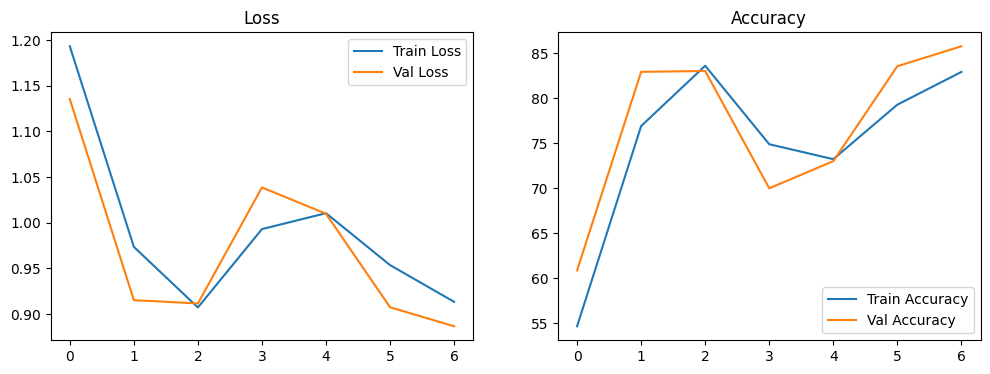

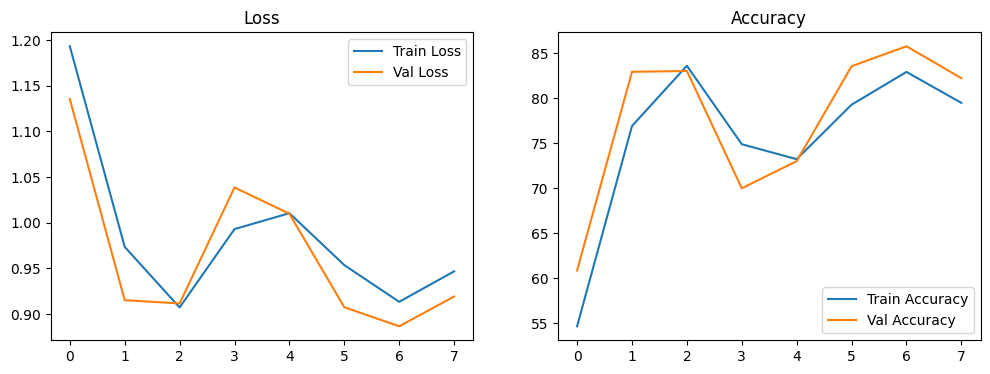

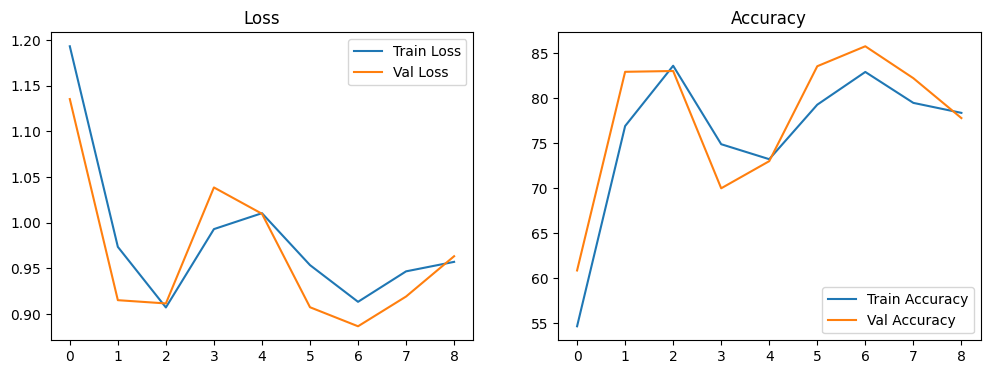

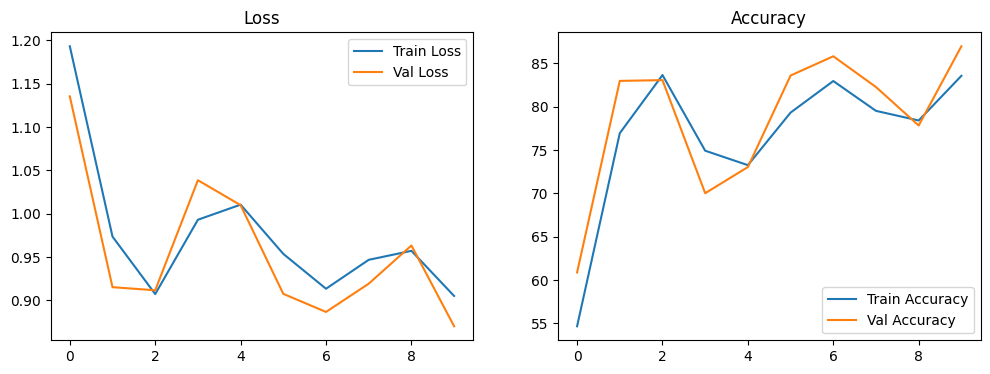

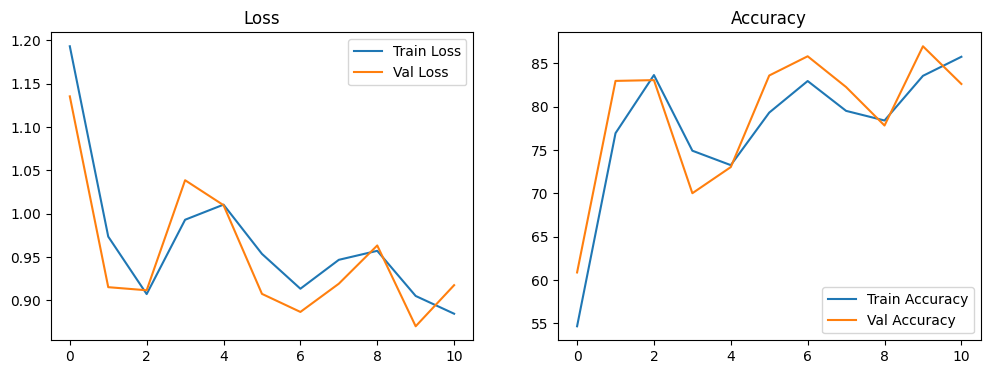

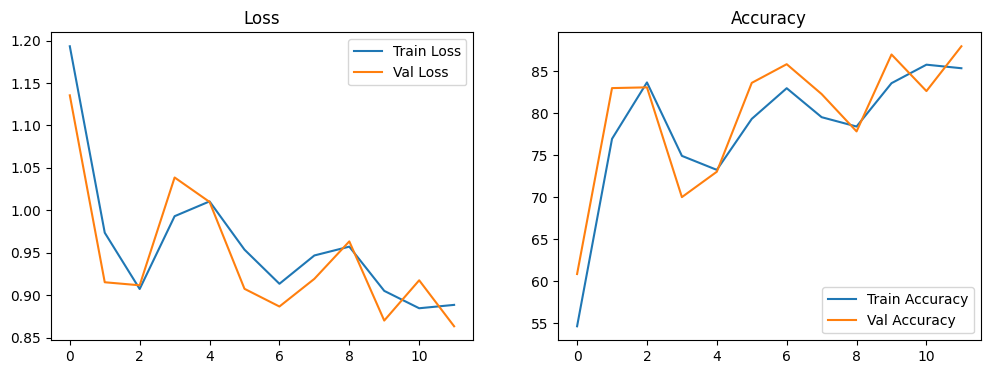

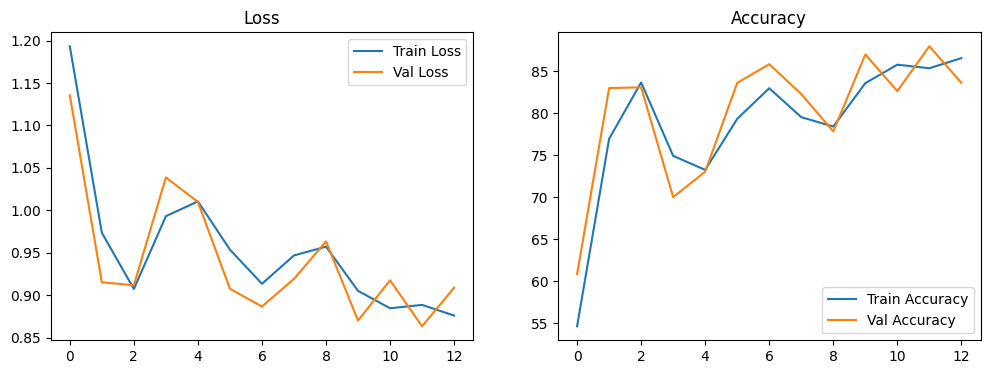

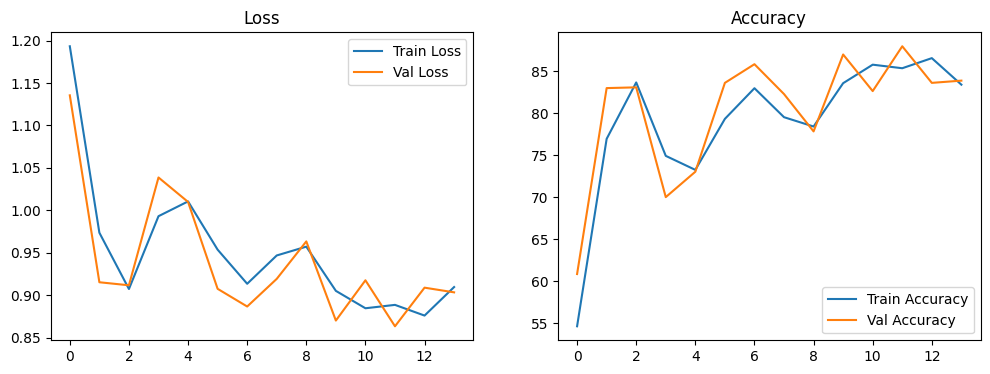

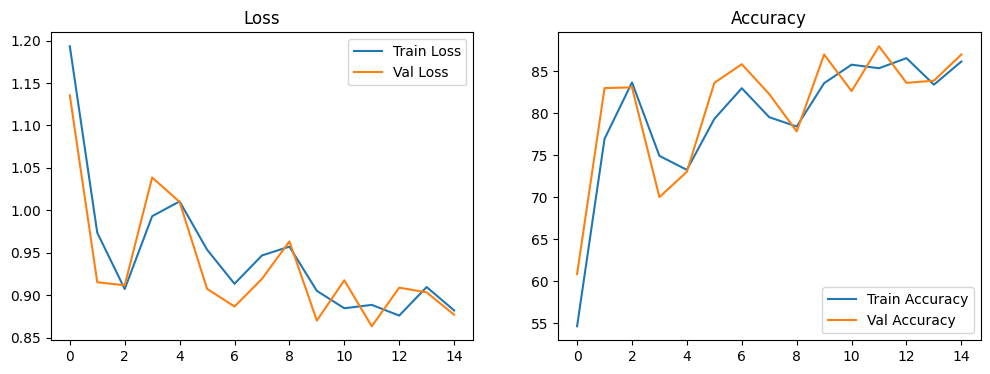

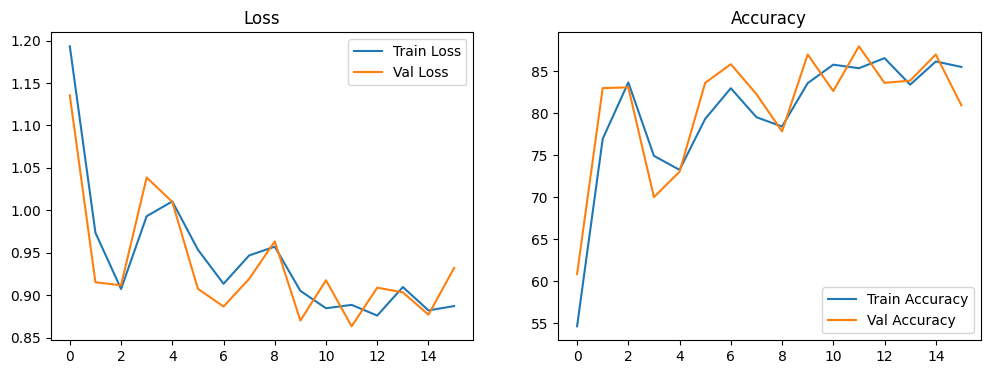

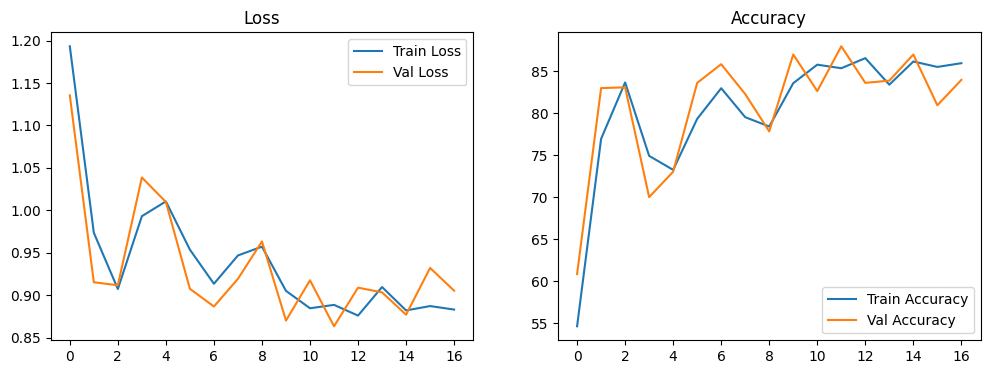

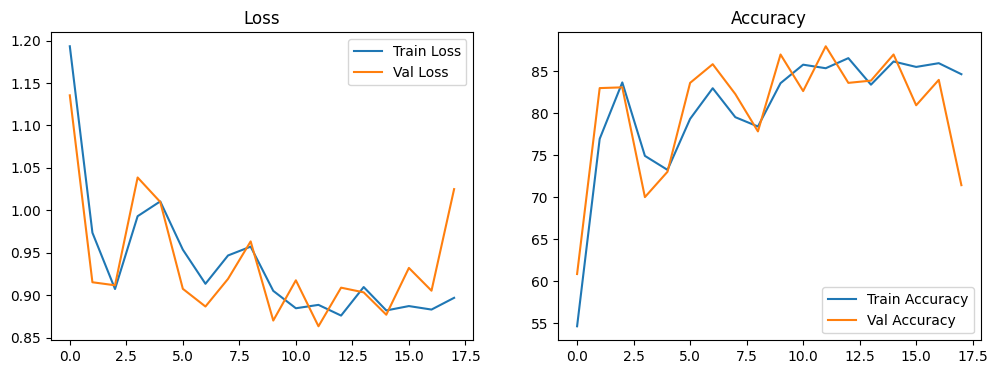

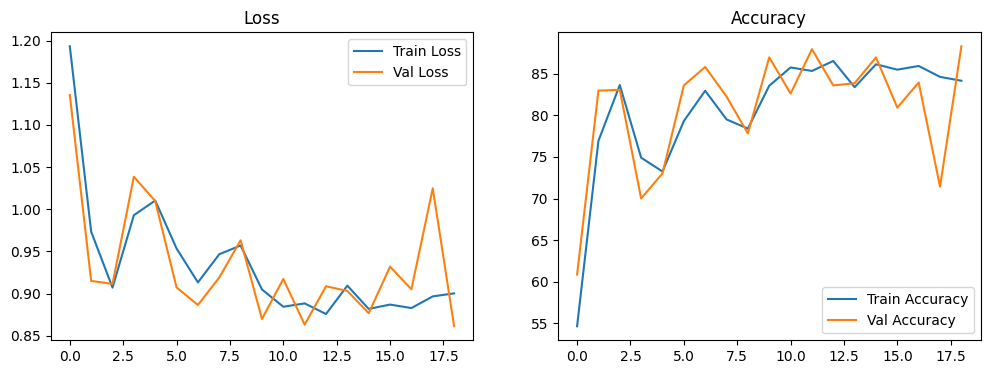

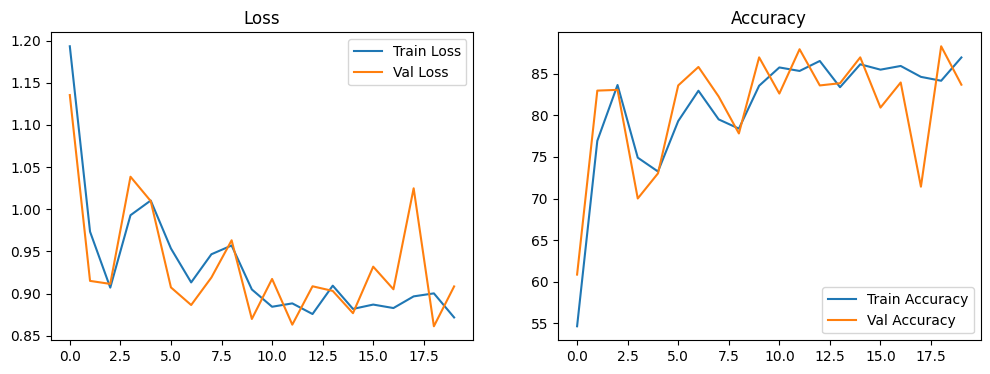

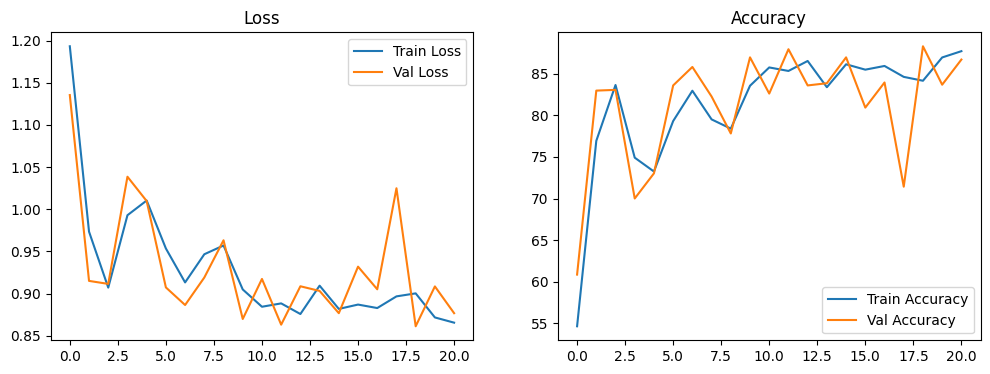

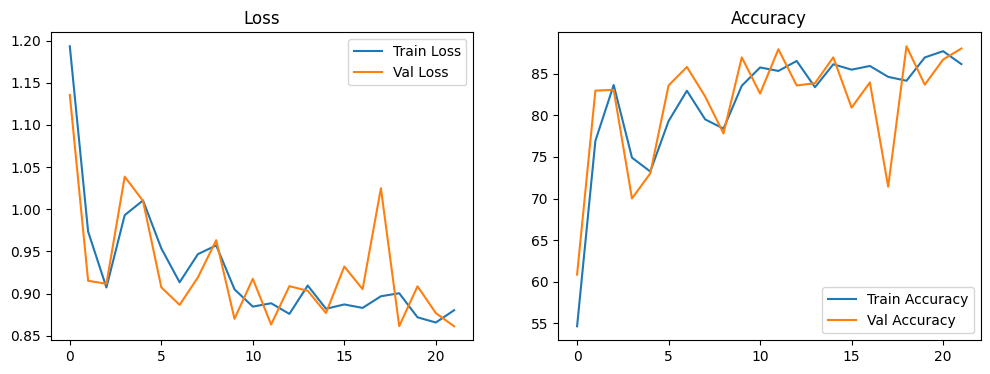

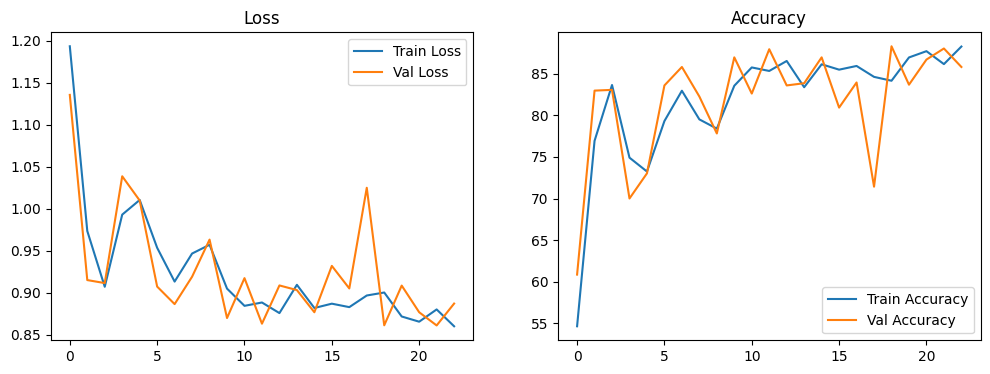

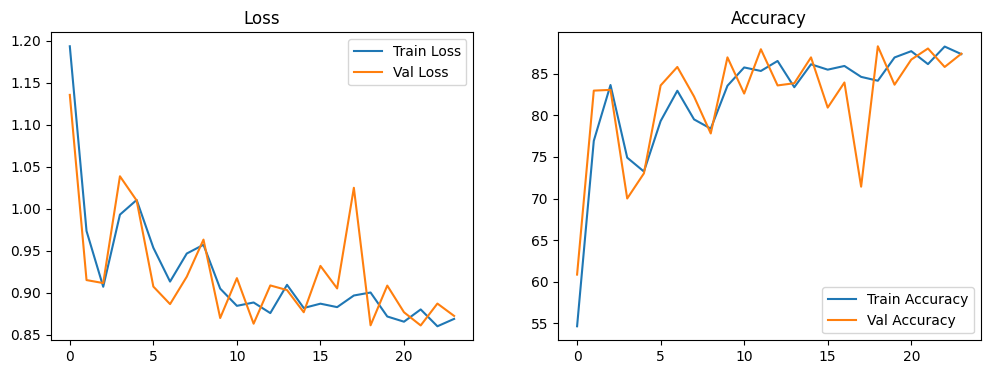

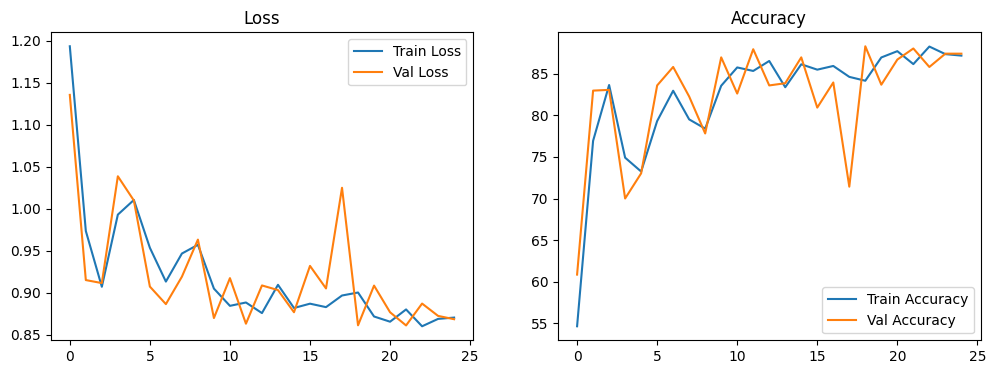

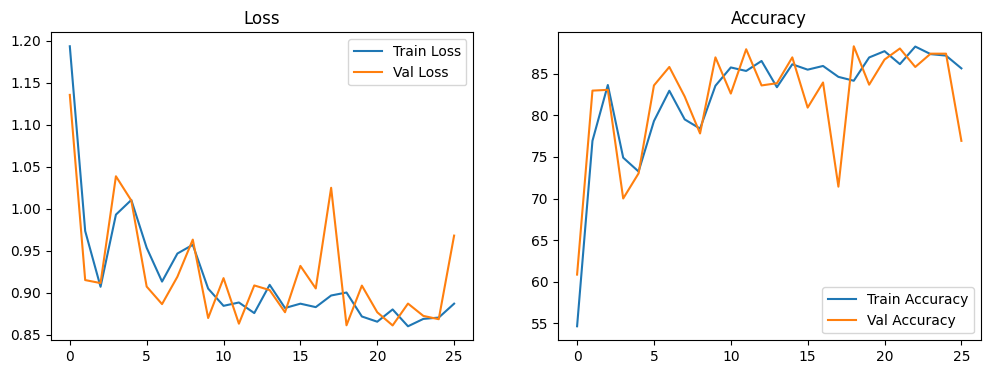

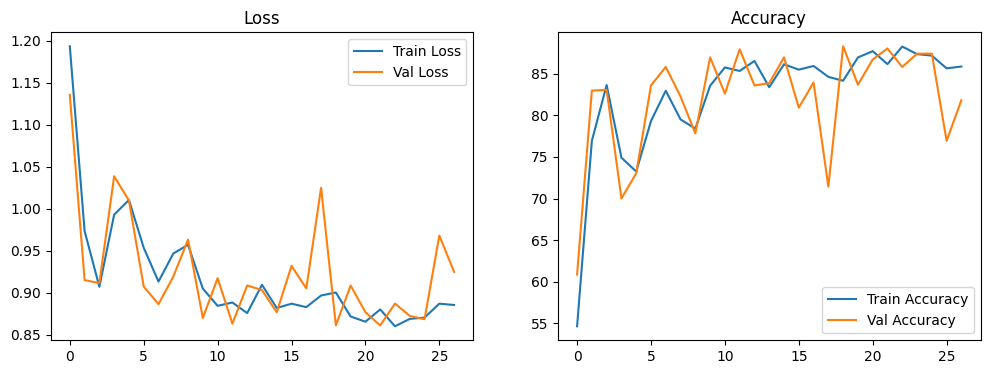

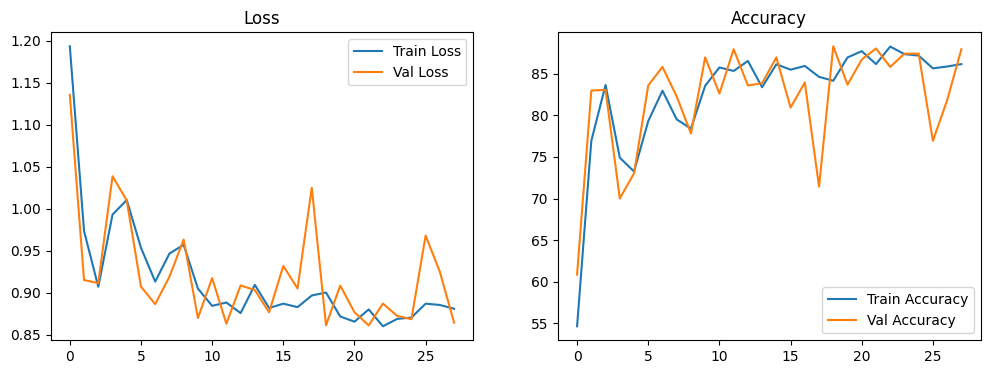

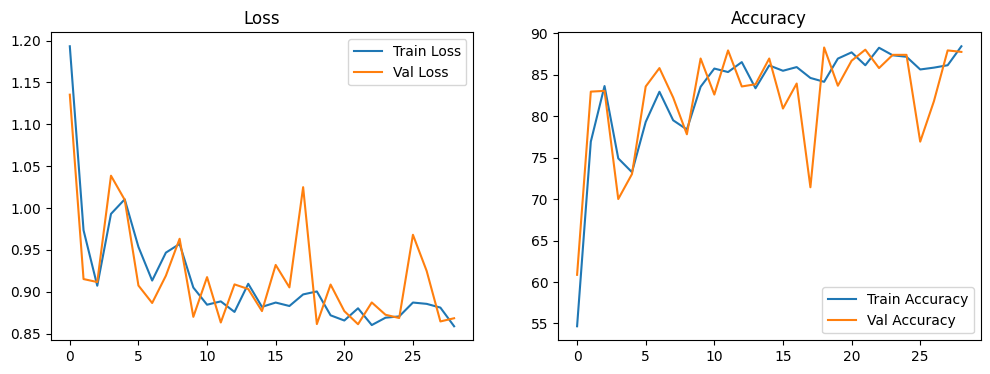

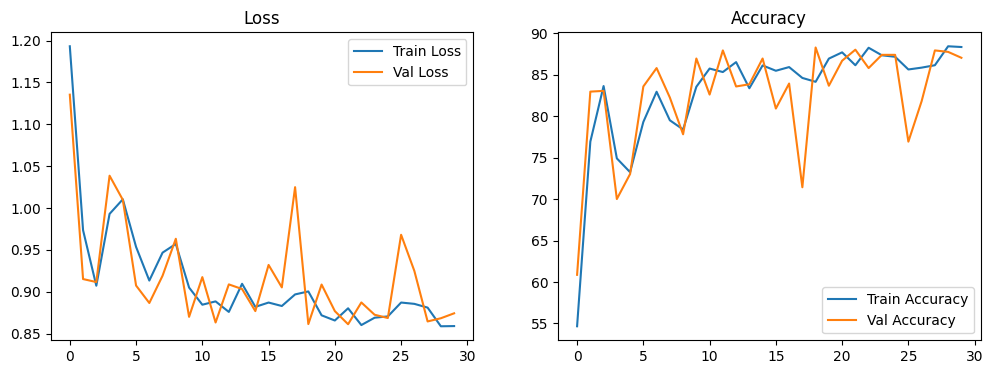

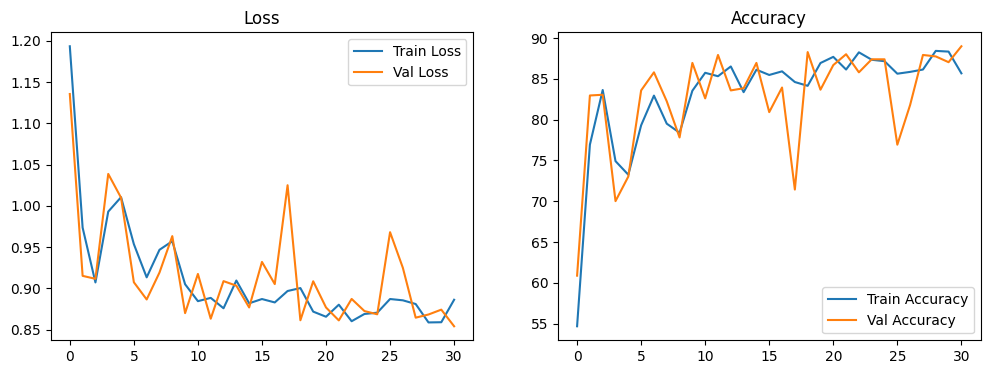

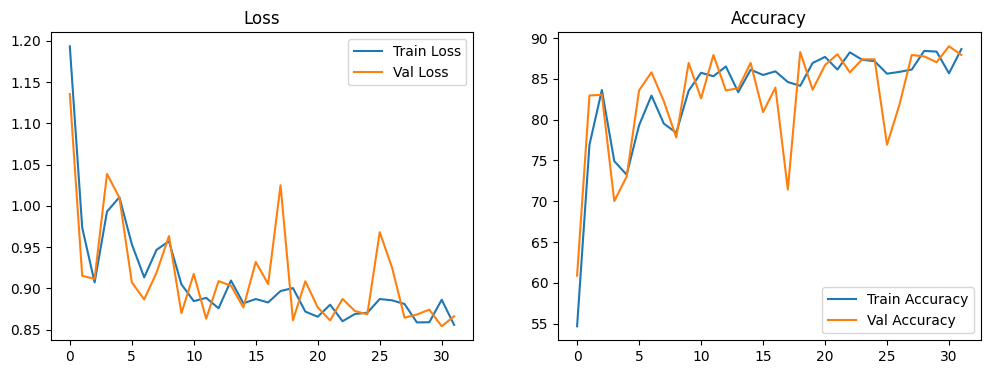

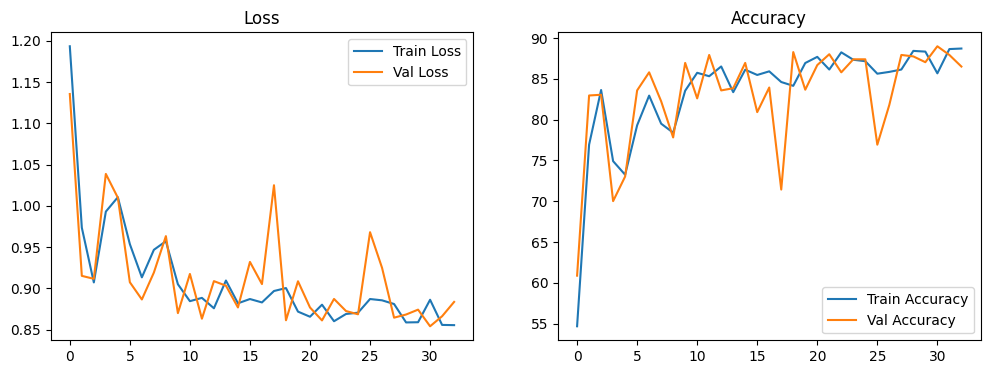

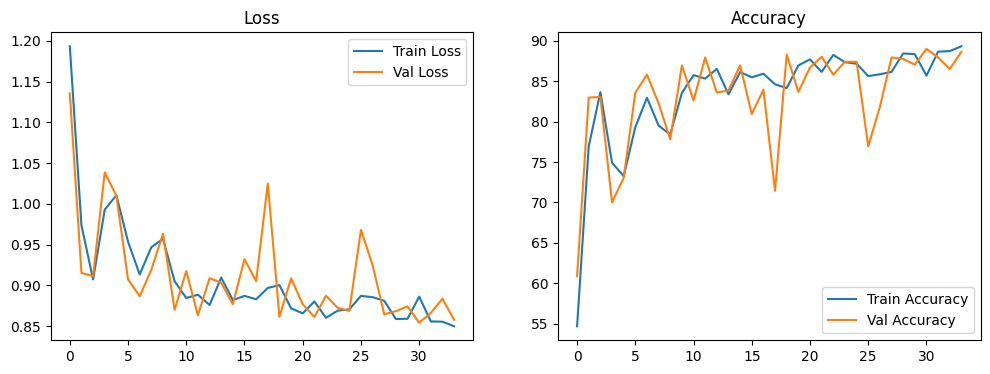

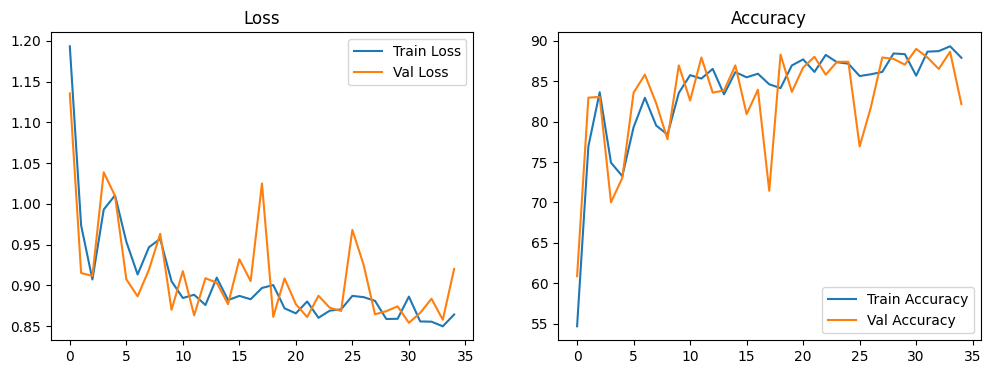

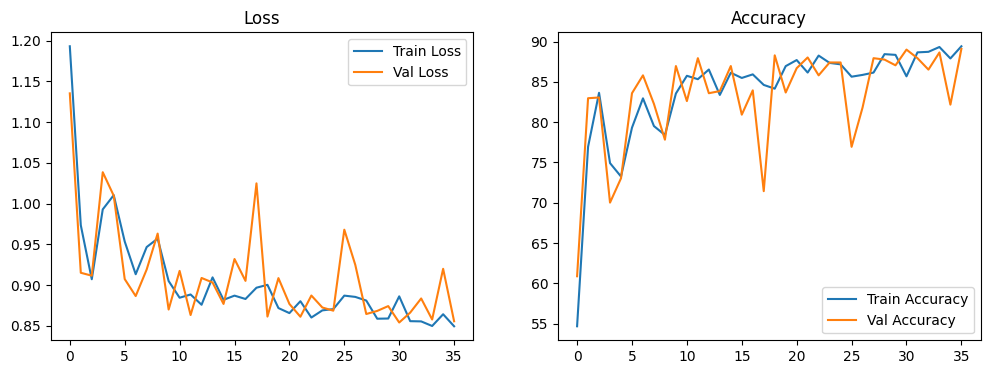

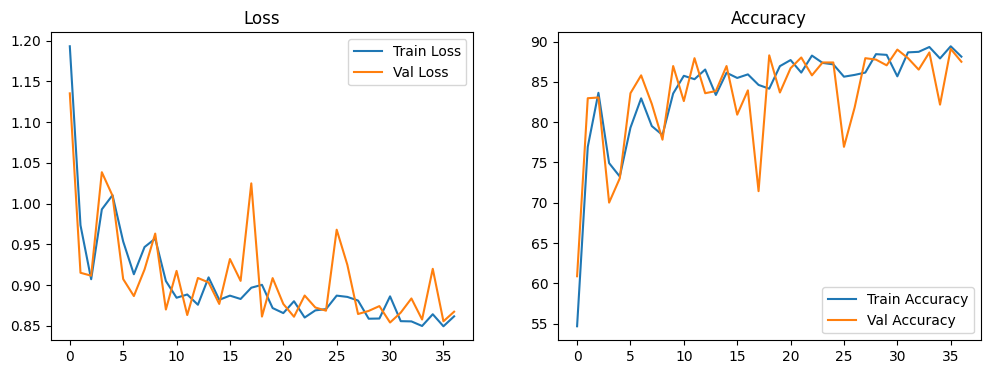

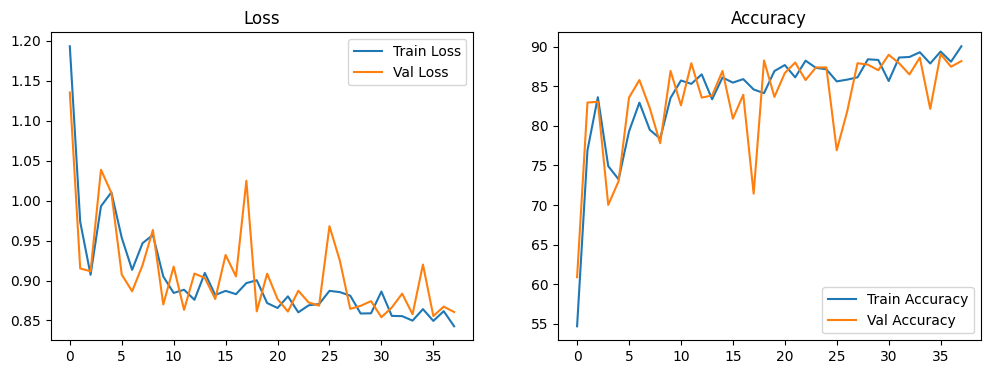

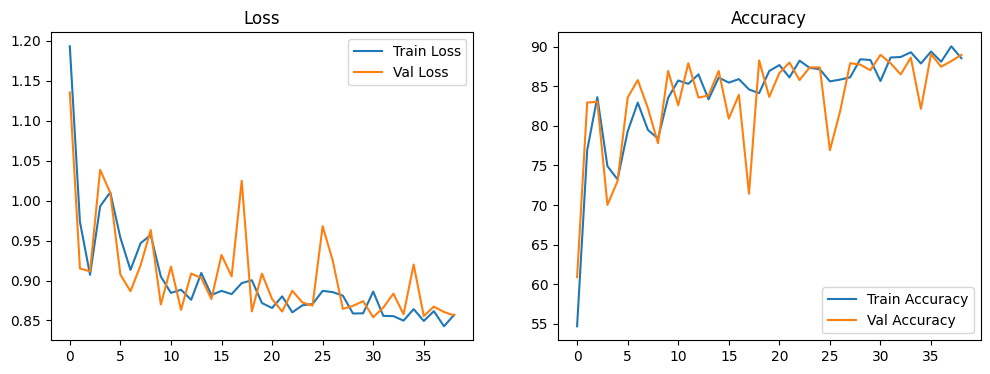

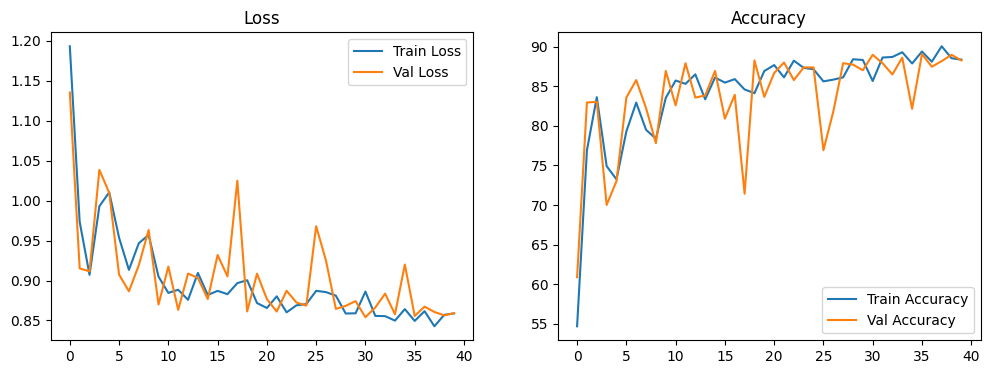

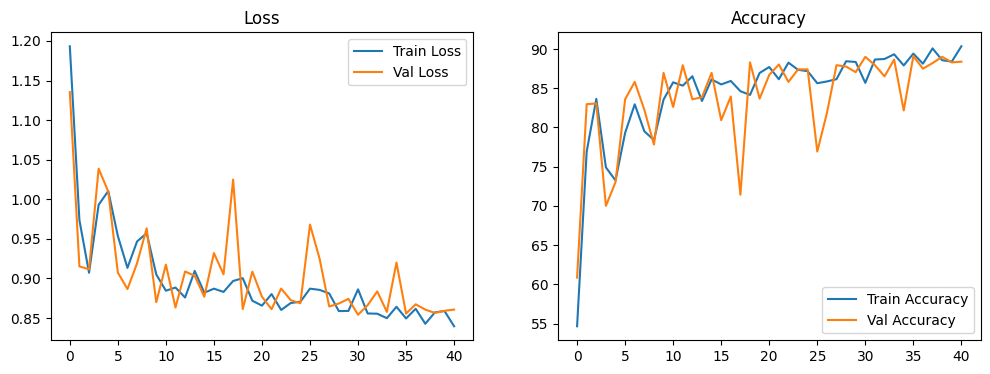

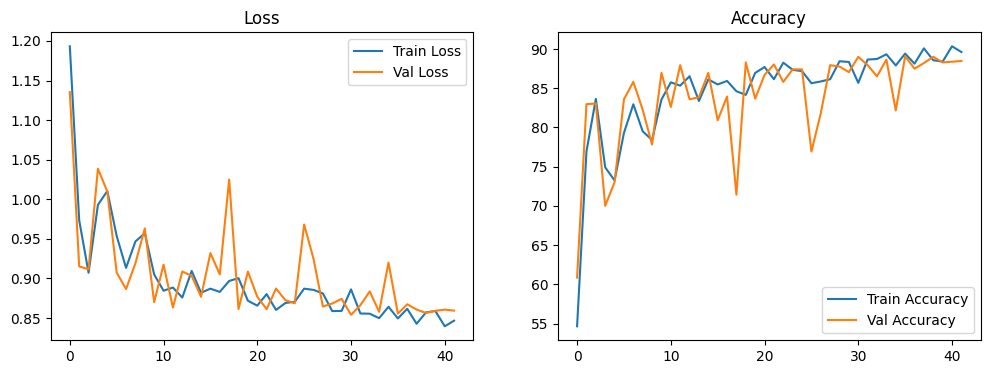

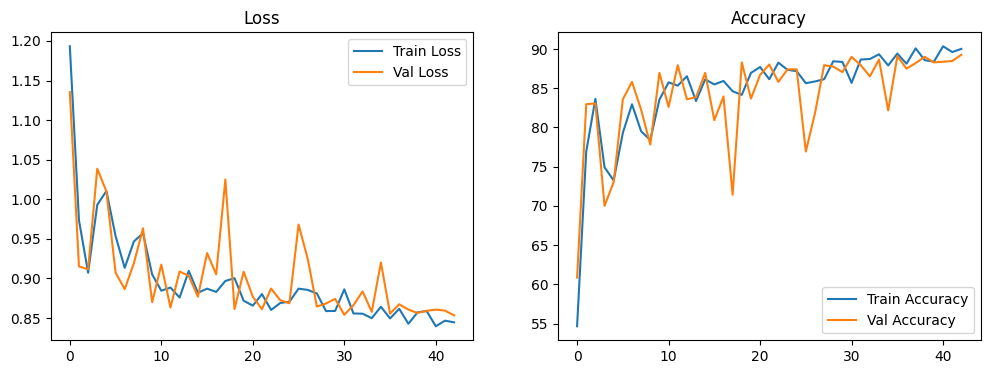

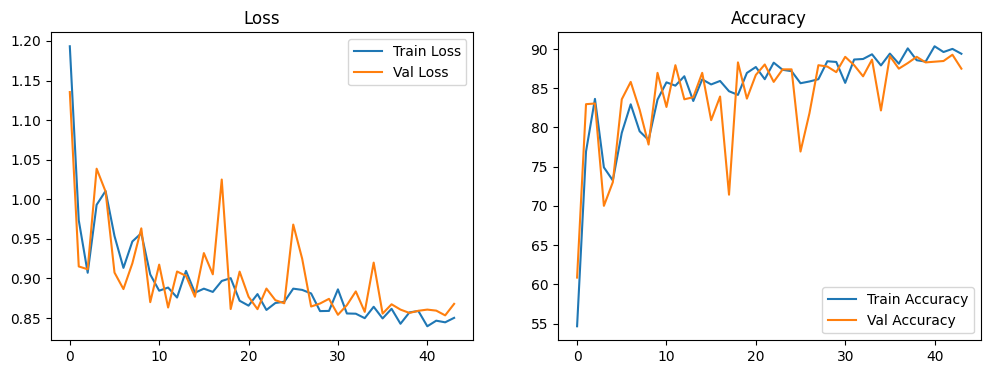

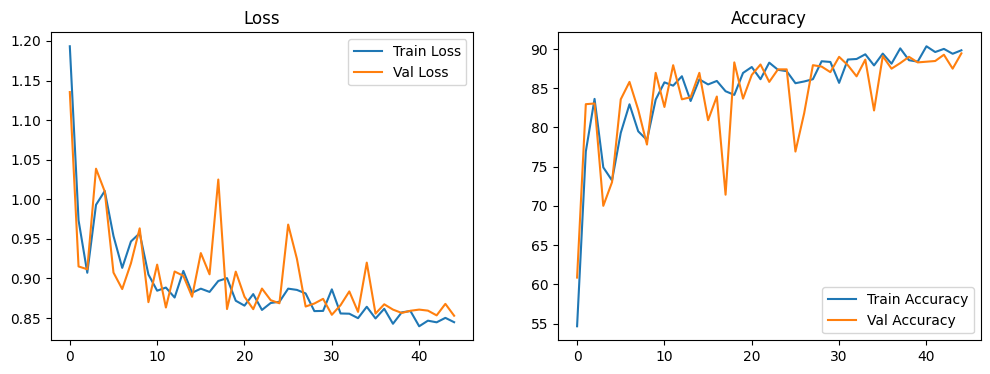

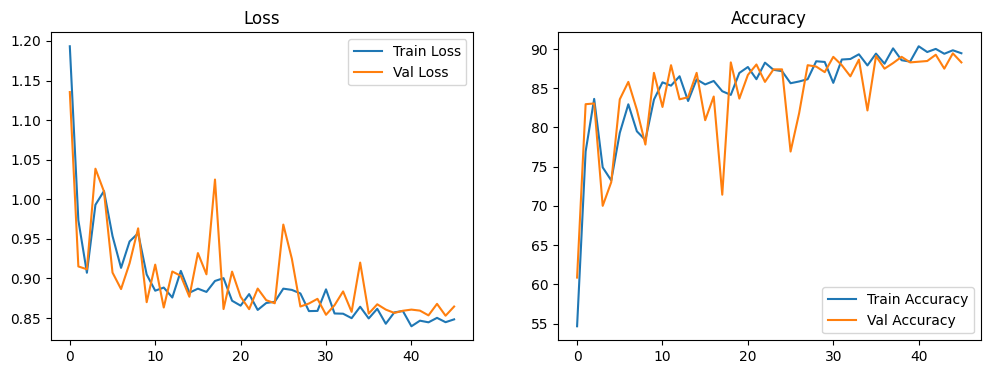

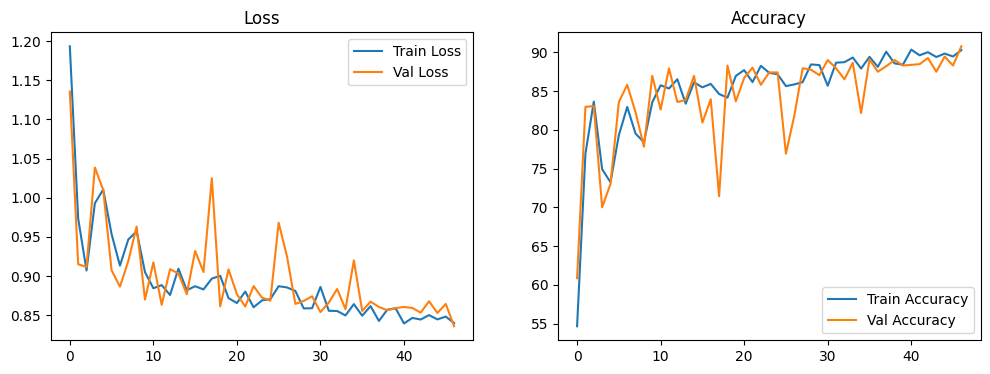

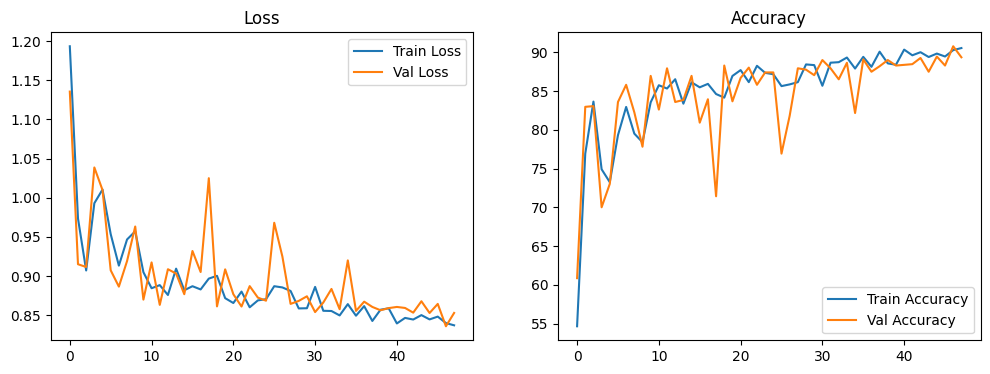

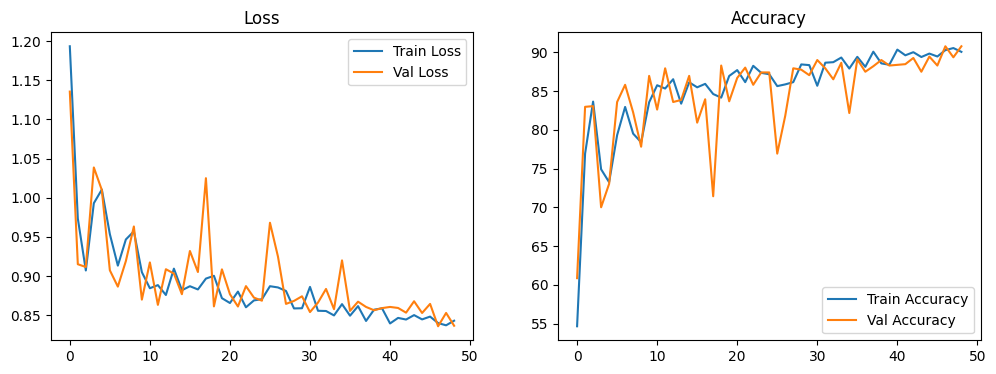

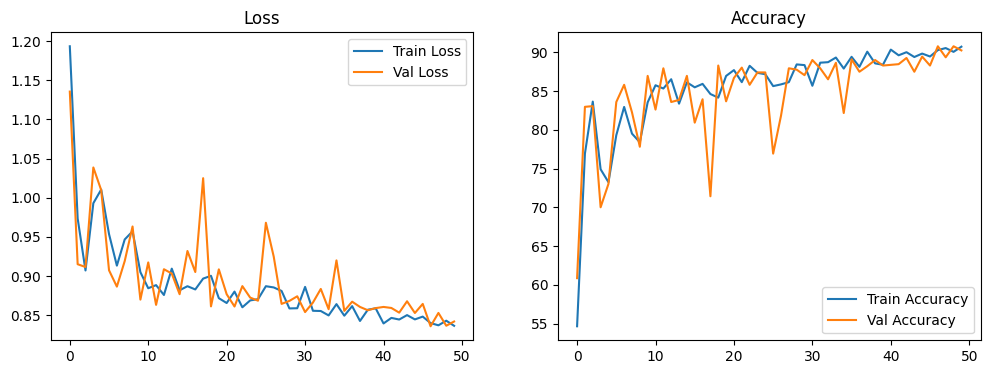

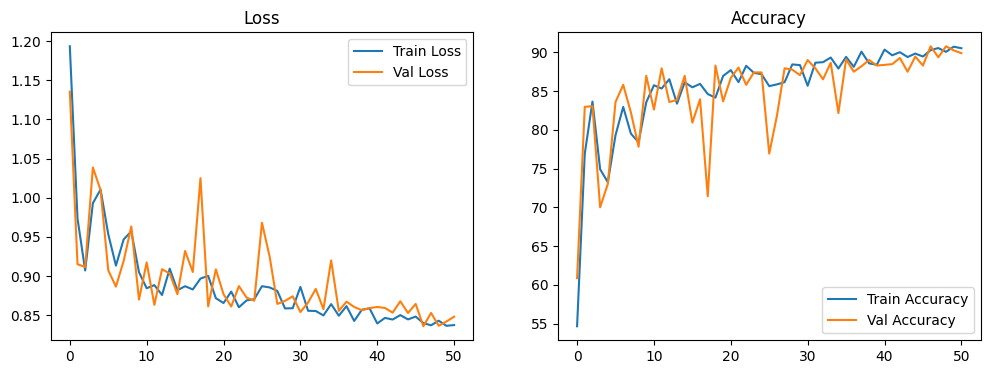

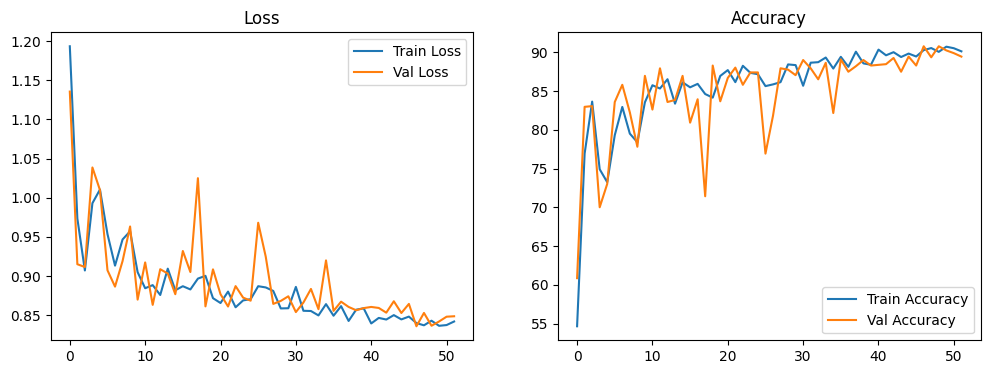

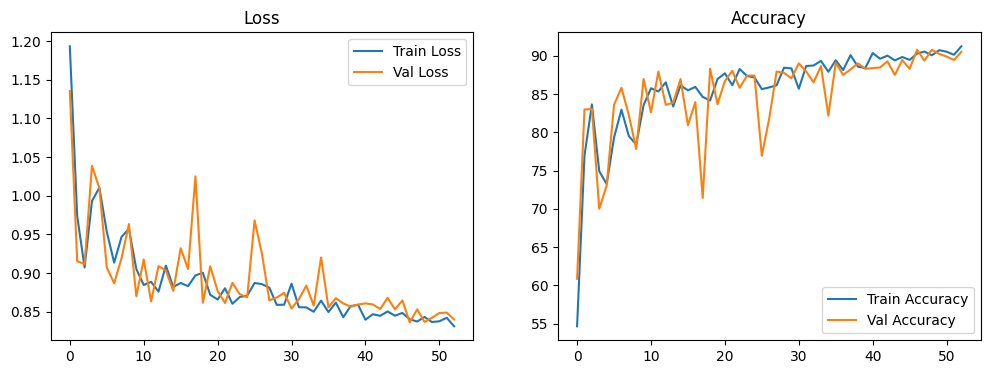

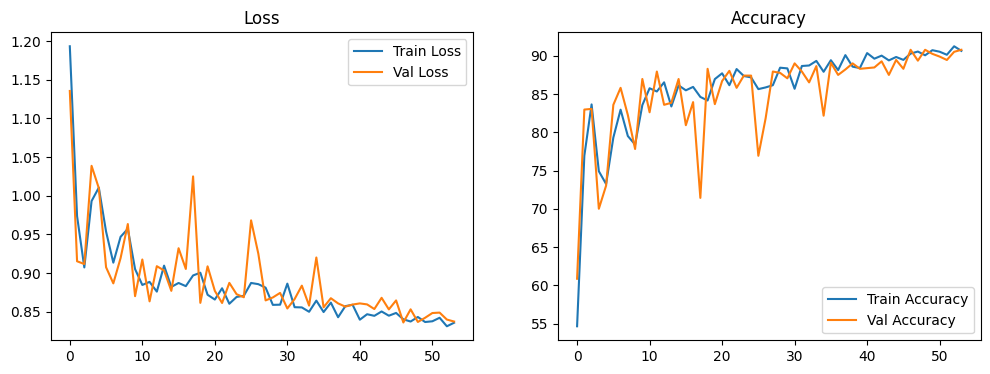

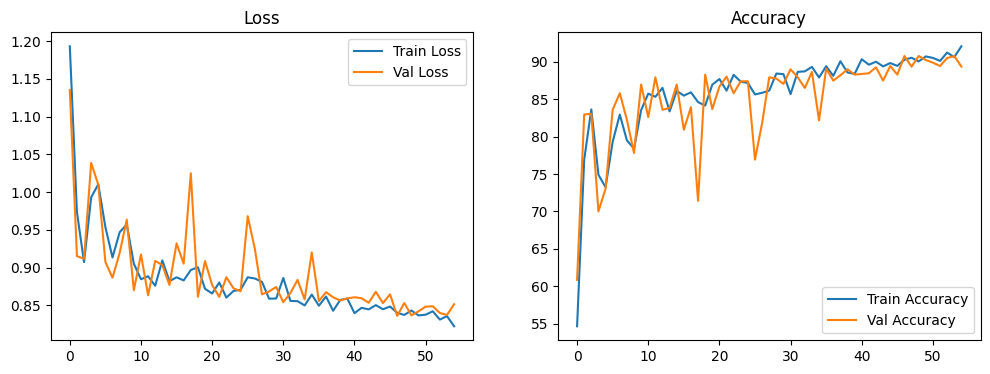

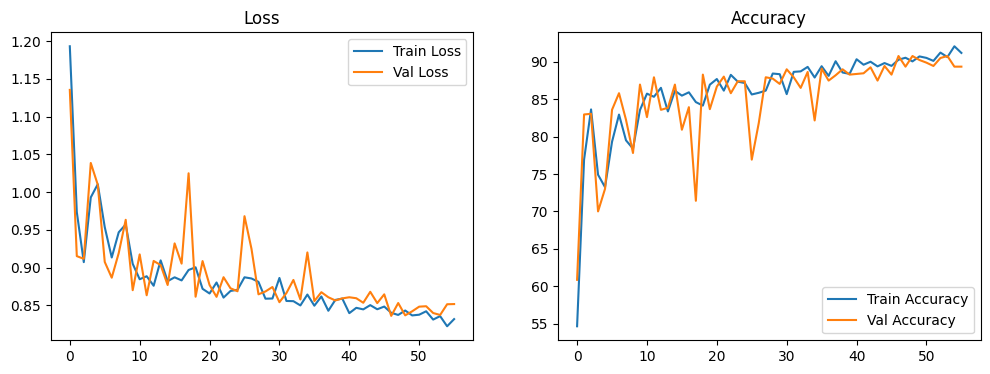

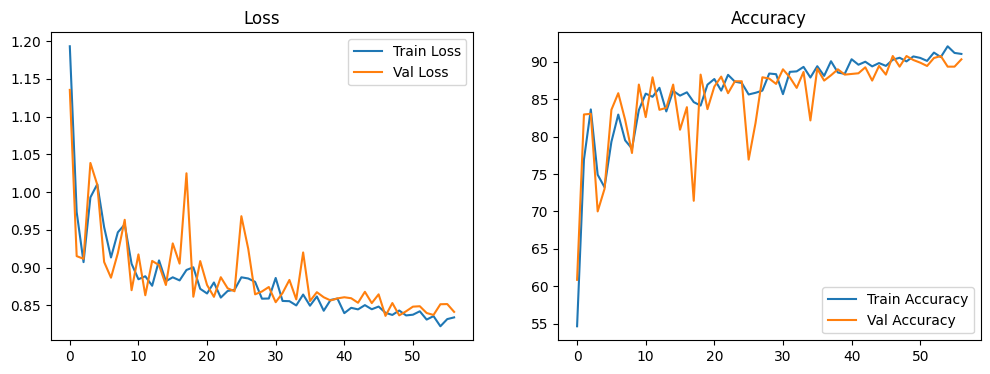

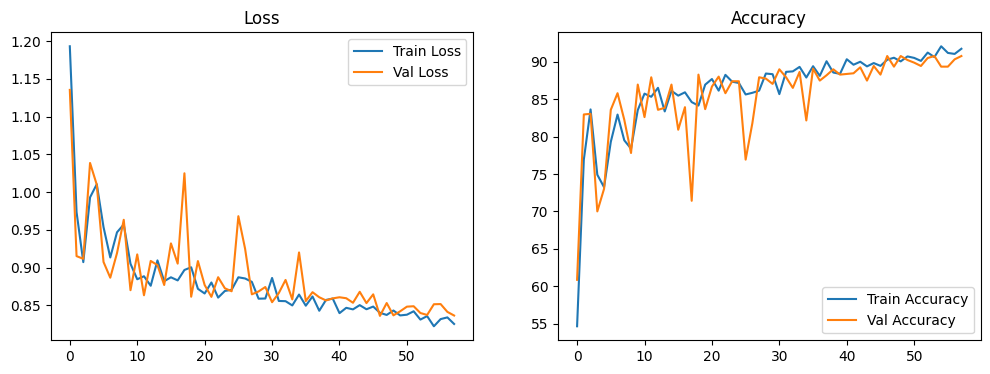

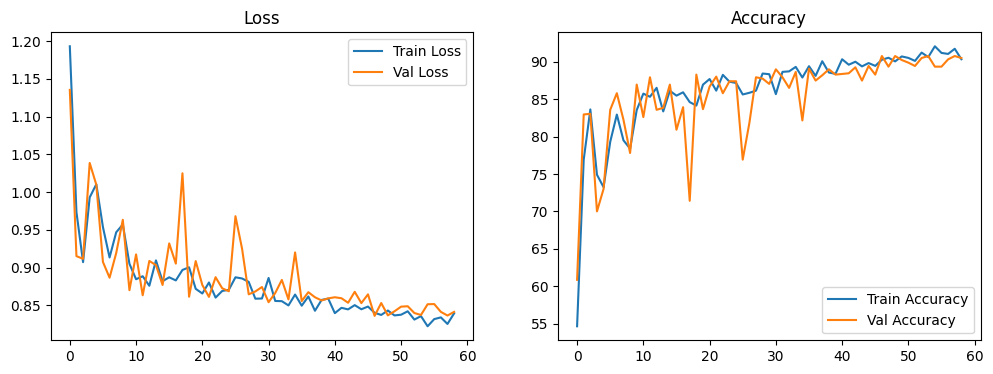

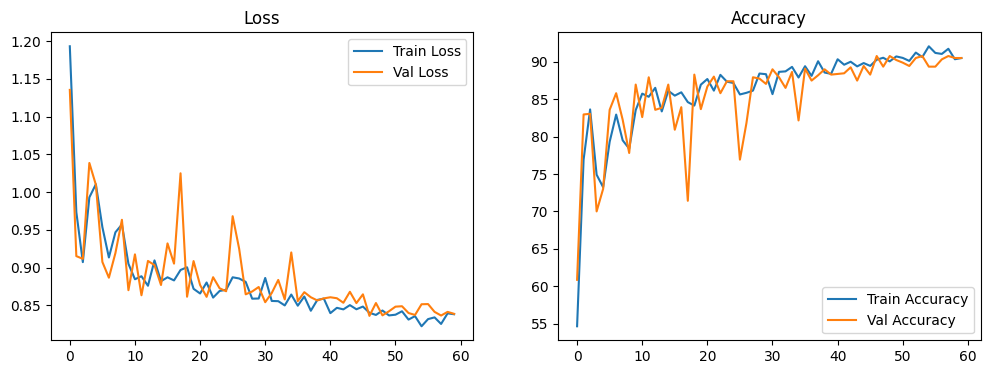

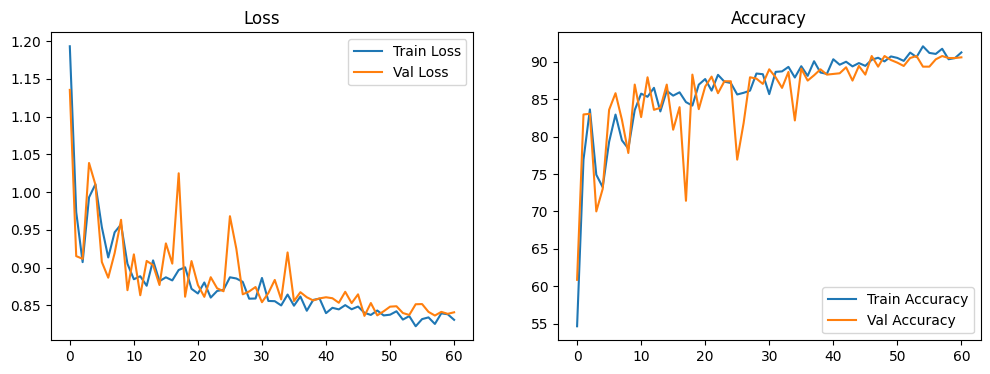

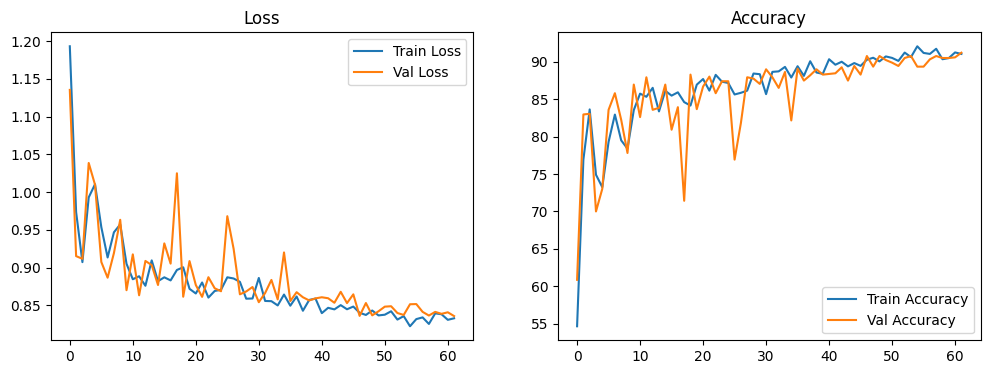

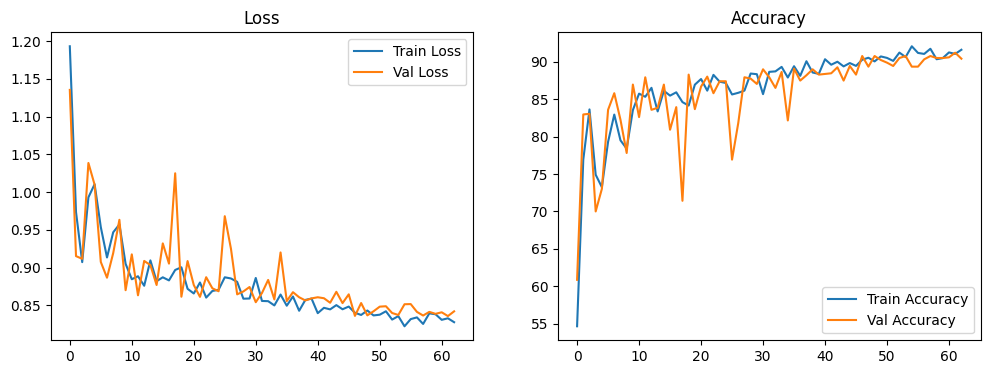

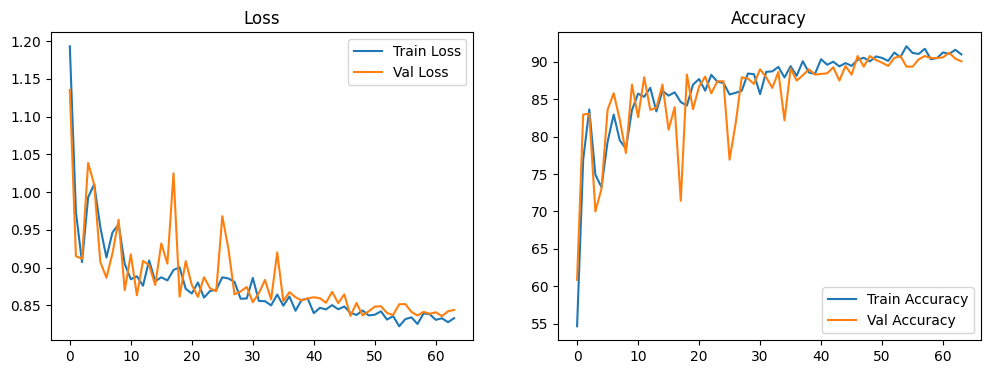

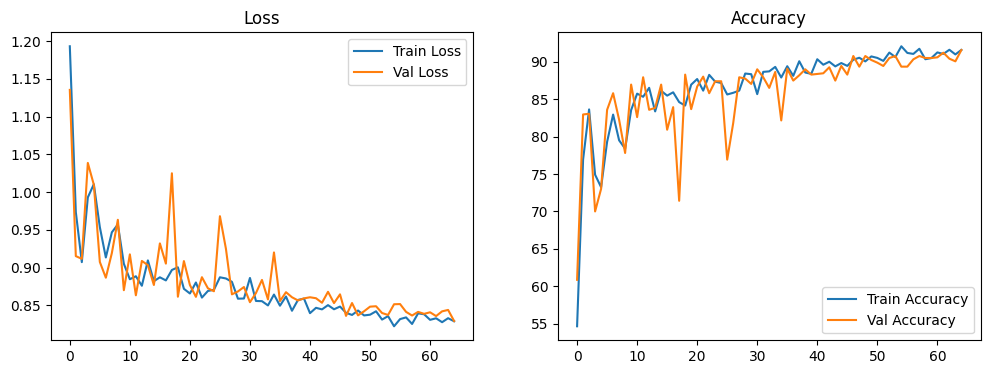

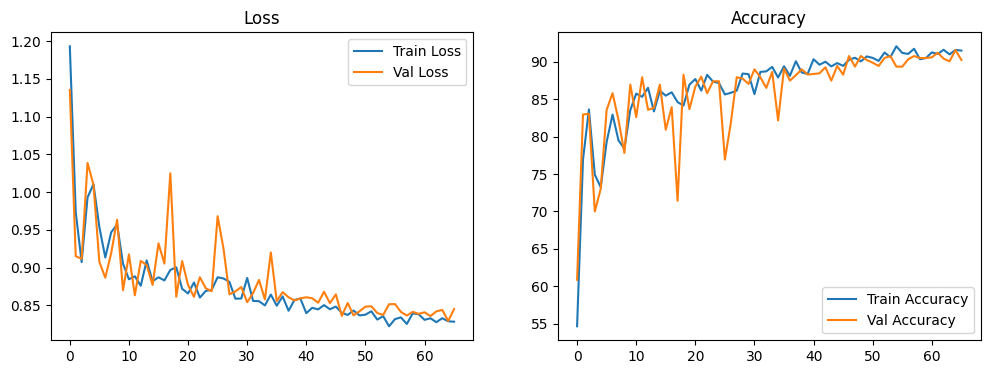

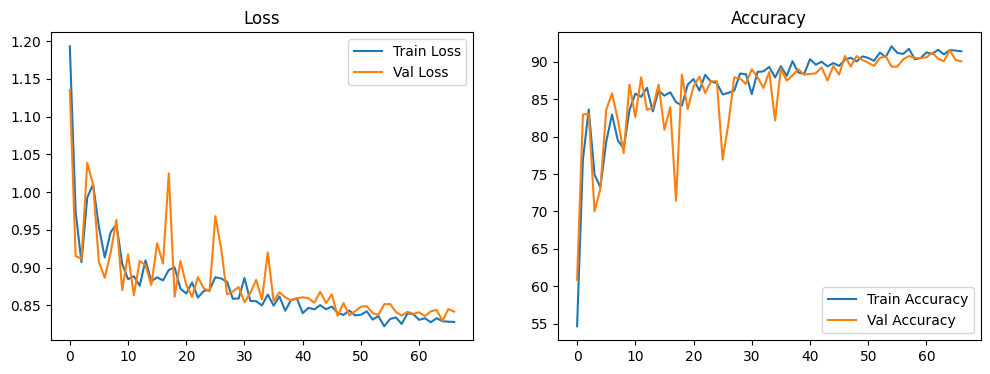

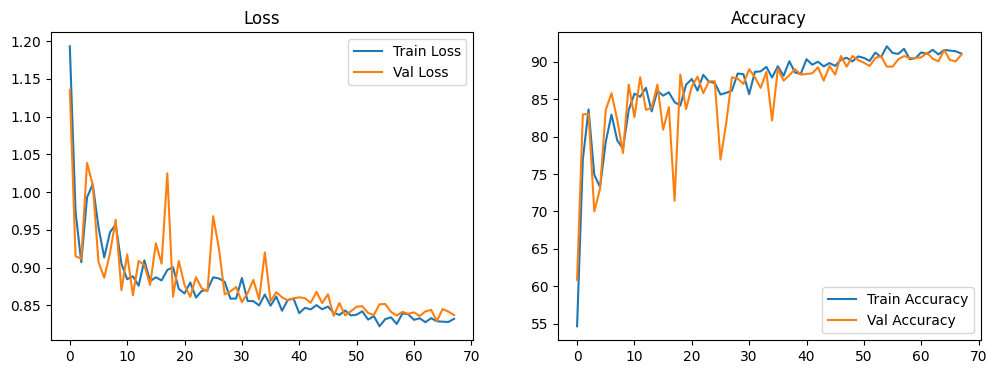

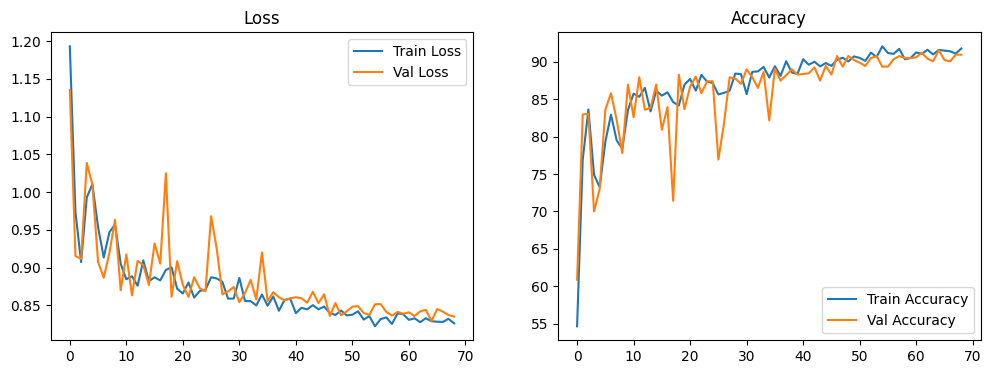

In [86]:
for epoch in tqdm(range(hyperparameters["num_epochs"]), desc="Epochs"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):  
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "improved_best_model_rsicb256.pth")
    
    scheduler.step()
    
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Val Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    display(fig)
    
    print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")

plt.close()

C:\Users\Stephen\AppData\Local\Temp\ipykernel_4616\1840651020.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("improved_best_model_rsicb

Improved Model Test Accuracy: 91.66%
Precision: 0.9181
Recall: 0.9166
F1-Score: 0.9165


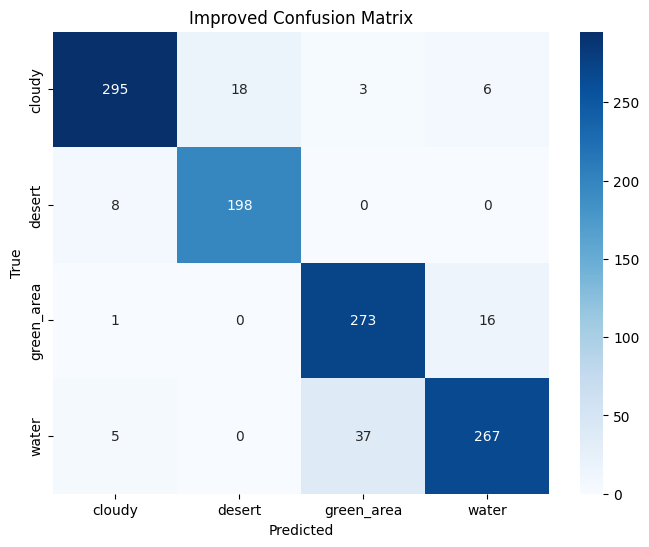

In [87]:
model.load_state_dict(torch.load("improved_best_model_rsicb256.pth"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"Improved Model Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Improved Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Type-2 (New Model)

In [37]:
class ImprovedLightweightCNNLSTM(nn.Module):
    def __init__(self, num_classes, model_params):
        super(ImprovedLightweightCNNLSTM, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, model_params["conv1_kernels"], kernel_size=model_params["conv1_kernel_size"], 
                      stride=model_params["conv1_stride"], padding=model_params["conv1_padding"]),
            nn.BatchNorm2d(model_params["conv1_kernels"]),
            nn.ReLU(),
            nn.Conv2d(model_params["conv1_kernels"], model_params["conv1_kernels"], kernel_size=3, 
                      padding=1, groups=model_params["conv1_kernels"]),  # Depthwise
            nn.Conv2d(model_params["conv1_kernels"], model_params["conv1_kernels"], kernel_size=1),  
            nn.MaxPool2d(kernel_size=model_params["pool1_size"], stride=model_params["pool1_stride"]),
            nn.Conv2d(model_params["conv1_kernels"], model_params["conv2_kernels"], 
                      kernel_size=model_params["conv2_kernel_size"], stride=model_params["conv2_stride"], 
                      padding=model_params["conv2_padding"]),
            nn.BatchNorm2d(model_params["conv2_kernels"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool2_size"], stride=model_params["pool2_stride"])
        )
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(model_params["conv2_kernels"], model_params["conv2_kernels"] // 8, kernel_size=1), 
            nn.ReLU(),
            nn.Conv2d(model_params["conv2_kernels"] // 8, model_params["conv2_kernels"], kernel_size=1),  
            nn.Sigmoid()
        )
        
        self.flatten = nn.Flatten()
        self.lstm_input_size = model_params["lstm_input_size"]  
        self.lstm = nn.LSTM(self.lstm_input_size, 64, num_layers=1, batch_first=True) 
        self.fc1 = nn.Linear(64, model_params["dense1_neurons"])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(model_params["dense1_neurons"], num_classes)
        
    def forward(self, x):
        x = self.cnn(x)
        se_weights = self.se(x)
        x = x * se_weights
        x = self.flatten(x)
        x = x.view(x.size(0), 1, -1)  
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [38]:
model_parameters = {
    "conv1_kernels": 16,
    "conv1_kernel_size": 3,
    "conv1_stride": 1,
    "conv1_padding": 1,
    "pool1_size": 2,
    "pool1_stride": 2,
    "conv2_kernels": 32,
    "conv2_kernel_size": 3,
    "conv2_stride": 1,
    "conv2_padding": 1,
    "pool2_size": 2,
    "pool2_stride": 2,
    "lstm_input_size": 32 * (hyperparameters["input_size"][0] // 4) * (hyperparameters["input_size"][1] // 4), 
    "lstm_sequence_length": 1,
    "dense1_neurons": 128
}
model = ImprovedLightweightCNNLSTM(num_classes=hyperparameters["num_classes"], model_params=model_parameters).to(device)
print("Improved model architecture defined.")

Improved model architecture defined.


In [25]:
if True:
    from torch.cuda.amp import GradScaler, autocast
    optimizer = optim.AdamW(model.parameters(), lr=hyperparameters["learning_rate"], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=hyperparameters["num_epochs"], eta_min=1e-6)
    scaler = GradScaler()
    best_val_f1 = 0.0

if False:
    try:
        model.load_state_dict(torch.load("best_model_rsicb256.pth"))
        print("Model loaded successfully from best_model_rsicb256.pth")
    except RuntimeError:
        print("Warning: Previous weights incompatible with new architecture. Initializing from scratch.")
        load_previous_weights = False
        
if not False:
    model = ImprovedLightweightCNNLSTM(num_classes=hyperparameters["num_classes"], model_params=model_parameters).to(device)
    print("Model initialized from scratch")
    
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

Model initialized from scratch


C:\Users\Stephen\AppData\Local\Temp\ipykernel_3620\3864523775.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


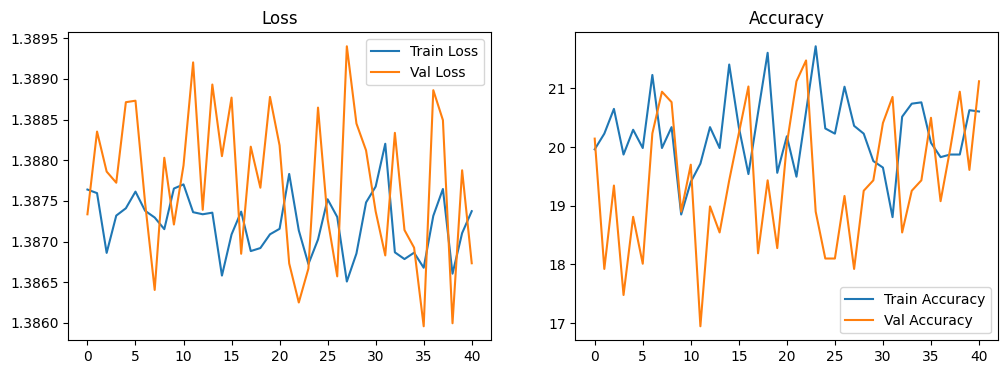

Epoch 41/70, Train Loss: 1.3874, Train Acc: 20.60%, Val Loss: 1.3867, Val Acc: 21.12%, Val F1: 0.2151


KeyboardInterrupt: 

In [27]:
criterion = torch.nn.CrossEntropyLoss() 

best_val_f1 = best_val_f1 if 'best_val_f1' in globals() else -1.0
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(hyperparameters["num_epochs"]), desc="Epochs"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / max(1, len(train_loader))
    train_acc  = 100.0 * correct / max(1, total)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / max(1, len(test_loader))
    val_acc  = 100.0 * correct / max(1, total)
    val_f1   = f1_score(all_labels, all_preds, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "./saved_model_rsi/improved_best_model_rsicb256_v2.pth")

    scheduler.step()

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses,   label='Val Loss')
    ax1.set_title('Loss'); ax1.legend()
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies,   label='Val Accuracy')
    ax2.set_title('Accuracy'); ax2.legend()
    display(fig)
    plt.close(fig)

    print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")


### Type-3 (New Dataset)

In [36]:
import torch
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [30]:
hyperparameters = {
    "learning_rate": 0.001,
    "batch_size": 256,
    "num_epochs": 70,
    "input_size": (64, 64),
    "num_classes": 35,
    "lstm_hidden_size": 98,
    "lstm_num_layers": 1,
    "patience": 1000
}
best_model_path = "./saved_model_rsi/improved_best_model_rsicb256_v3.pkl"

In [19]:
class RSICB256Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.classes = []

        for outer in os.listdir(root_dir):
            outer_path = os.path.join(root_dir, outer)
            if not os.path.isdir(outer_path):
                continue
            for inner in os.listdir(outer_path):
                inner_path = os.path.join(outer_path, inner)
                if not os.path.isdir(inner_path):
                    continue
                if inner not in self.classes:
                    self.classes.append(inner)
                label = self.classes.index(inner)
                for fname in os.listdir(inner_path):
                    if fname.lower().endswith(".tif"):
                        self.samples.append((os.path.join(inner_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB") 
        if self.transform:
            img = self.transform(img)
        return img, label

In [20]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Lambda(lambda x: kornia.filters.laplacian(x.unsqueeze(0), kernel_size=3).squeeze(0) + x)
])

In [21]:
data_dir = "./RSI-CB256"
dataset = RSICB256Dataset(root_dir=data_dir, transform=transform)

from torch.utils.data import random_split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=True, num_workers=0)
test_loader  = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"], shuffle=False,  num_workers=0)

print(f"Detected {len(dataset.classes)} classes: {dataset.classes}")

Detected 35 classes: ['city_building', 'container', 'residents', 'storage_room', 'bare_land', 'dry_farm', 'green_farmland', 'desert', 'mountain', 'sandbeach', 'snow_mountain', 'airplane', 'pipeline', 'town', 'airport_runway', 'avenue', 'bridge', 'crossroads', 'highway', 'marina', 'parkinglot', 'coastline', 'dam', 'hirst', 'lakeshore', 'river', 'sea', 'stream', 'artificial_grassland', 'forest', 'mangrove', 'river_protection_forest', 'sapling', 'shrubwood', 'sparse_forest']


In [22]:
class LightweightCNNLSTM(nn.Module):
    def __init__(self, num_classes, model_params, hyperparams, input_size=(256, 256), device='cpu'):
        super(LightweightCNNLSTM, self).__init__()
        self.model_params = model_params
        self.hyperparams = hyperparams

        self.cnn = nn.Sequential(
            nn.Conv2d(3, model_params["conv1_kernels"], kernel_size=model_params["conv1_kernel_size"], 
                      stride=model_params["conv1_stride"], padding=model_params["conv1_padding"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool1_size"], stride=model_params["pool1_stride"]),
            nn.Conv2d(model_params["conv1_kernels"], model_params["conv2_kernels"], 
                      kernel_size=model_params["conv2_kernel_size"], stride=model_params["conv2_stride"], 
                      padding=model_params["conv2_padding"]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=model_params["pool2_size"], stride=model_params["pool2_stride"])
        )

        self.flatten = nn.Flatten()

        with torch.no_grad():
            dummy = torch.zeros(1, 3, *input_size) 
            cnn_out = self.cnn(dummy)
            flat_size = cnn_out.view(1, -1).size(1)
            features_per_step = flat_size // model_params["lstm_sequence_length"]


        self.lstm = nn.LSTM(
            input_size=features_per_step,
            hidden_size=hyperparams["lstm_hidden_size"], 
            num_layers=hyperparams["lstm_num_layers"], 
            batch_first=True
        )

        self.fc1 = nn.Linear(hyperparams["lstm_hidden_size"], model_params["dense1_neurons"])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(model_params["dense1_neurons"], num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = x.view(x.size(0), self.model_params["lstm_sequence_length"], -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [23]:
model = LightweightCNNLSTM(
    num_classes=hyperparameters["num_classes"],
    model_params=model_parameters,
    hyperparams=hyperparameters,
    input_size=(256, 256),
    device=device
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters["learning_rate"])

In [24]:
best_val_acc = 0.0
patience = hyperparameters["patience"]
counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

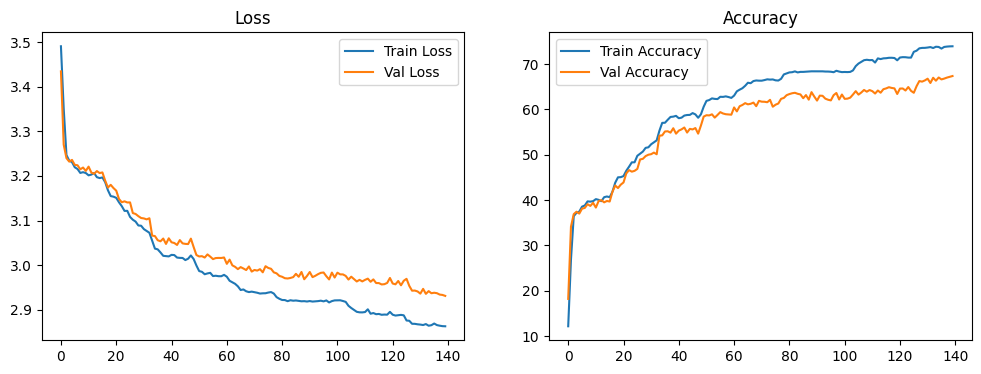

Epoch 70/70, Train Loss: 2.8630, Train Acc: 73.92%, Val Loss: 2.9311, Val Acc: 67.35%


In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for epoch in tqdm(range(hyperparameters["num_epochs"]), desc="Epochs"):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        counter = 0
    else:
        counter += 1
    
    clear_output(wait=True)
    ax1.clear()
    ax2.clear()
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Loss')
    ax1.legend()
    ax2.plot(train_accuracies, label='Train Accuracy')
    ax2.plot(val_accuracies, label='Val Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    display(fig)
    
    print(f"Epoch {epoch+1}/{hyperparameters['num_epochs']}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    if counter >= patience:
        print("Early stopping triggered.")
        break

plt.close()

In [32]:
model.load_state_dict(torch.load(best_model_path))
model.eval()
all_preds = []
all_labels = []

C:\Users\Stephen\AppData\Local\Temp\ipykernel_1928\807321686.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [33]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [34]:
accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

C:\Program Files\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Test Accuracy: 67.35%
Precision: 0.5589
Recall: 0.6735
F1-Score: 0.6001


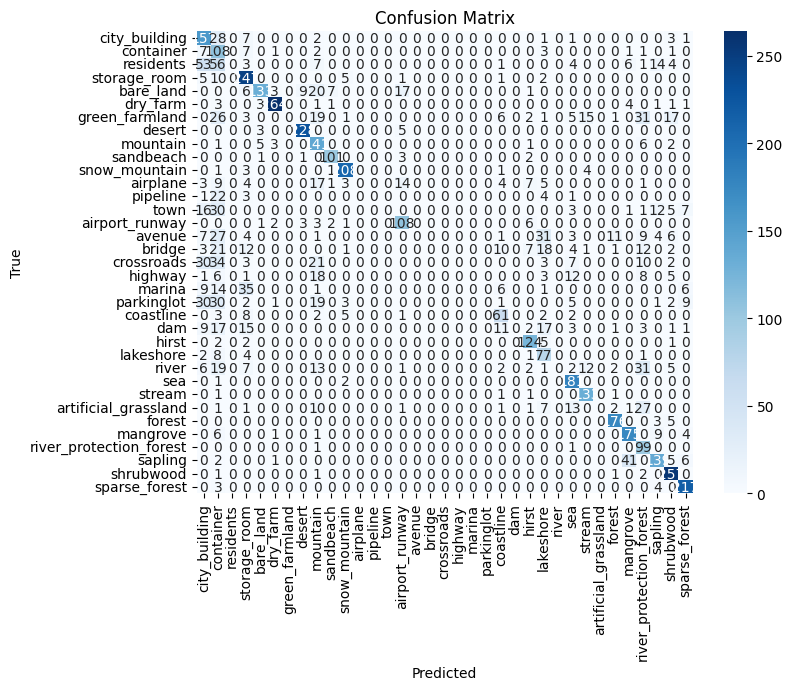

In [35]:
print(f"Final Test Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()